In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# from keras.models import Sequential
# from keras.layers import Dense

# from keras.optimizers import Adam

warnings.filterwarnings('ignore')

/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Belgium

## train/test split

In [16]:
belgium = pd.read_csv('univariate_df_Belgium.csv')
belgium = belgium.set_index('date')
belgium.index = pd.to_datetime(belgium.index)
belgium
belgium = belgium.drop('Unnamed: 0', axis=1)

In [17]:
belgium.sort_index()
train_size = int(len(belgium) * 0.8)
belgium_train, belgium_test = belgium[0:train_size], belgium[train_size:]
belgium_train=belgium.iloc[:-30 ]
belgium_test=belgium.iloc[-30: ]
print(belgium_train.shape, belgium_test.shape)

(172, 1) (30, 1)


In [14]:
belgium_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(belgium_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer')

,TEST SET,TRAINING SET
date,,
2020-03-01,NaN,0.0
2020-03-08,NaN,0.0
2020-03-15,NaN,9.0
2020-03-22,NaN,140.0
2020-03-29,NaN,602.0
...,...,...
2023-12-10,0.0,NaN
2023-12-17,0.0,NaN
2023-12-24,0.0,NaN


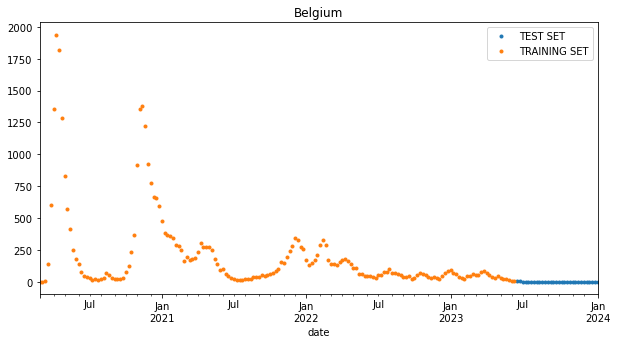

In [21]:
_ = belgium_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(belgium_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Belgium', style='.')

## basic ARIMA (1,1,1)

In [27]:
model=ARIMA(belgium_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -981.565
Date:                Fri, 16 Feb 2024   AIC                           1969.131
Time:                        15:58:22   BIC                           1978.556
Sample:                    03-01-2020   HQIC                          1972.955
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5017      0.033     15.408      0.000       0.438       0.566
ma.L1          0.6131      0.045     13.676      0.000       0.525       0.701
sigma2      5630.8415    221.138     25.463      0.000    5197.419    6064.264
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):              1939.19
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

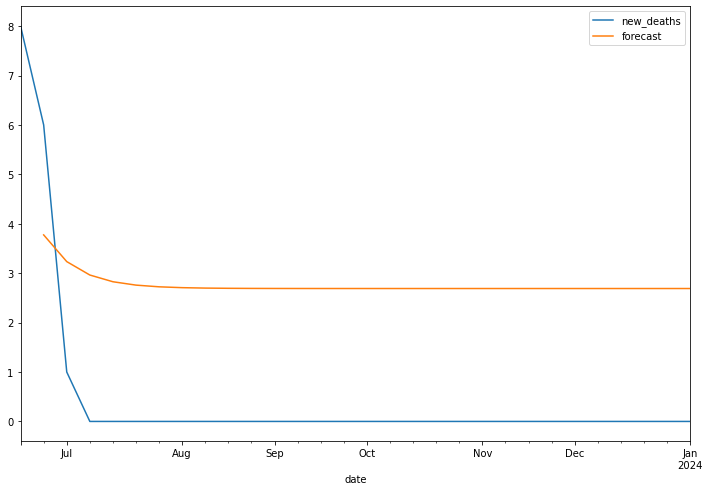

In [30]:
belgium_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
belgium_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search ARIMA

In [31]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(belgium_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
3,1,4,1933.060736
7,2,4,1934.569341
11,3,4,1935.831130
15,4,4,1937.827730
10,3,3,1942.469356
13,4,2,1942.637668
6,2,3,1943.186595
14,4,3,1946.070743
8,3,1,1948.934011
4,2,1,1949.707495


In [32]:
model=ARIMA(belgium_train['new_deaths'],order=(1,1,4))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -960.530
Date:                Fri, 16 Feb 2024   AIC                           1933.061
Time:                        16:02:10   BIC                           1951.911
Sample:                    03-01-2020   HQIC                          1940.709
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7148      0.040     18.019      0.000       0.637       0.793
ma.L1          0.4024      1.571      0.256      0.798      -2.677       3.482
ma.L2         -0.2828      2.195     -0.129      0.897      -4.585       4.019
ma.L3         -0.6167      1.752     -0.352      0.725      -4.051       2.817
ma.L4         -0.5020      0.788     -0.637      0.524      -2.046       1.042
sigma2      4305.1309   6729.274      0.640      0.522   -8884.004    1.75e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              2851.08
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             2.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

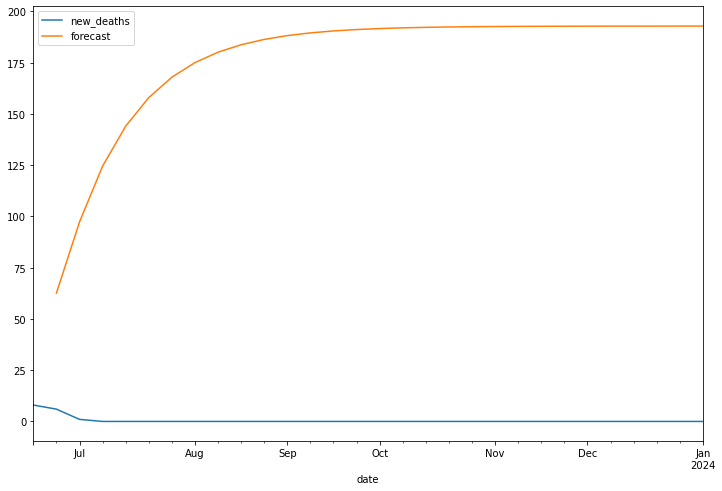

In [33]:
belgium_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
belgium_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search SARIMA

In [35]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(belgium_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])



1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.48273D+00    |proj g|=  1.48624D-01


 This problem is unconstrained.



At iterate    5    f=  5.42205D+00    |proj g|=  9.68260D-03

At iterate   10    f=  5.42057D+00    |proj g|=  5.85688D-03

At iterate   15    f=  5.39545D+00    |proj g|=  3.17409D-02

At iterate   20    f=  5.39422D+00    |proj g|=  1.06780D-03

At iterate   25    f=  5.39342D+00    |proj g|=  2.93689D-02

At iterate   30    f=  5.39086D+00    |proj g|=  4.86190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     50      1     0     0   1.148D-06   5.391D+00
  F =   5.3908541634138833     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43006D+00    |proj g|=  5.16093D-02

At iterate    5    f=  5.42179D+00    |proj g|=  2.95332D-03

At iterate   10    f=  5.39572D+00    |proj g|=  5.14028D-02

At iterate   15    f=  5.38978D+00    |proj g|=  1.22395D-02

At iterate   20    f=  5.38843D+00    |proj g|=  1.92883D-03

At iterate   25    f=  5.38785D+00    |proj g|=  1.87690D-03

At iterate   30    f=  5.38686D+00    |proj g|=  6.77527D-03

At iterate   35    f=  5.38678D+00    |proj g|=  3.78995D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  5.42216D+00    |proj g|=  4.16526D-02

At iterate   10    f=  5.41788D+00    |proj g|=  3.03778D-03

At iterate   15    f=  5.40374D+00    |proj g|=  3.84336D-02

At iterate   20    f=  5.39339D+00    |proj g|=  4.52140D-03

At iterate   25    f=  5.39241D+00    |proj g|=  2.59850D-02

At iterate   30    f=  5.38730D+00    |proj g|=  8.73596D-03

At iterate   35    f=  5.38700D+00    |proj g|=  6.47256D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     47      1     0     0   1.623D-06   5.387D+00
  F =   5.3869982167604062     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43640D+00    |proj g|=  9.26093D-02

At iterate    5    f=  5.41802D+00    |proj g|=  6.99441D-03

At iterate   10    f=  5.41617D+00    |proj g|=  1.68841D-02

At iterate   15    f=  5.38974D+00    |proj g|=  1.70707D-02

At iterate   20    f=  5.38836D+00    |proj g|=  1.72208D-03

At iterate   25    f=  5.38812D+00    |proj g|=  1.98189D-03

At iterate   30    f=  5.38779D+00    |proj g|=  5.95693D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  5.36809D+00    |proj g|=  3.00483D-02

At iterate   10    f=  5.36648D+00    |proj g|=  2.30675D-03

At iterate   15    f=  5.36379D+00    |proj g|=  9.03680D-03

At iterate   20    f=  5.36322D+00    |proj g|=  4.62445D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     26      1     0     0   1.256D-05   5.363D+00
  F =   5.3632182186493074     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.36724D+00    |proj g|=  1.29970D-03

At iterate   10    f=  5.36705D+00    |proj g|=  5.20494D-03

At iterate   15    f=  5.36157D+00    |proj g|=  9.59911D-03

At iterate   20    f=  5.36102D+00    |proj g|=  1.41196D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     26      1     0     0   1.493D-05   5.361D+00
  F =   5.3610043658783981     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.37423D+00    |proj g|=  5.01078D-02

At iterate   10    f=  5.36059D+00    |proj g|=  2.45765D-03

At iterate   15    f=  5.36038D+00    |proj g|=  5.90589D-03

At iterate   20    f=  5.35683D+00    |proj g|=  4.44908D-03

At iterate   25    f=  5.35670D+00    |proj g|=  8.17508D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     29      1     0     0   2.342D-05   5.357D+00
  F =   5.3566998871193450     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43156D+00    |proj g|=  2.63619D-01

At iterate    5    f=  5.36089D+00    |proj g|=  1.45557D-02

At iterate   10    f=  5.36051D+00    |proj g|=  3.80488D-03

At iterate   15    f=  5.35883D+00    |proj g|=  2.22400D-02

At iterate   20    f=  5.35749D+00    |proj g|=  1.06976D-03

At iterate   25    f=  5.35683D+00    |proj g|=  3.67770D-03

At iterate   30    f=  5.35584D+00    |proj g|=  1.86887D-03

At iterate   35    f=  5.35582D+00    |proj g|=  8.38656D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   10    f=  5.36980D+00    |proj g|=  3.08413D-03

At iterate   15    f=  5.36135D+00    |proj g|=  7.80365D-02

At iterate   20    f=  5.34107D+00    |proj g|=  1.23681D-02

At iterate   25    f=  5.34087D+00    |proj g|=  1.29280D-03

At iterate   30    f=  5.34078D+00    |proj g|=  1.23117D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     36      1     0     0   5.986D-06   5.341D+00
  F =   5.3407816545995042     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  5.37070D+00    |proj g|=  3.06345D-03

At iterate   10    f=  5.36599D+00    |proj g|=  2.23050D-02

At iterate   15    f=  5.34109D+00    |proj g|=  3.63781D-02

At iterate   20    f=  5.33846D+00    |proj g|=  3.29174D-03

At iterate   25    f=  5.33841D+00    |proj g|=  6.56251D-05

At iterate   30    f=  5.33841D+00    |proj g|=  2.63272D-04

At iterate   35    f=  5.33841D+00    |proj g|=  1.33282D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     44      1     0     0   6.852D-05   5.338D+00
  F =   5.3384055855988803     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.36678D+00    |proj g|=  2.30415D-02

At iterate   10    f=  5.36383D+00    |proj g|=  4.67355D-03

At iterate   15    f=  5.35654D+00    |proj g|=  4.05197D-02

At iterate   20    f=  5.33258D+00    |proj g|=  2.37277D-03

At iterate   25    f=  5.33254D+00    |proj g|=  5.26411D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     30      1     0     0   1.011D-05   5.333D+00
  F =   5.3325360526739702     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  5.36439D+00    |proj g|=  4.83703D-03

At iterate   10    f=  5.36370D+00    |proj g|=  7.12743D-03

At iterate   15    f=  5.33768D+00    |proj g|=  5.58310D-02

At iterate   20    f=  5.33228D+00    |proj g|=  1.73368D-03

At iterate   25    f=  5.33215D+00    |proj g|=  2.60262D-03

At iterate   30    f=  5.33207D+00    |proj g|=  1.29694D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     37      1     0     0   2.571D-05   5.332D+00
  F =   5.3320653597732903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.35145D+00    |proj g|=  6.22579D-02

At iterate   10    f=  5.34580D+00    |proj g|=  3.75028D-03

At iterate   15    f=  5.32999D+00    |proj g|=  1.79577D-02

At iterate   20    f=  5.32166D+00    |proj g|=  7.62469D-03

At iterate   25    f=  5.31478D+00    |proj g|=  4.22014D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     38      1     0     0   1.544D-05   5.315D+00
  F =   5.3146328240401939     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.41094D+00    |proj g|=  3.15610D-01

At iterate    5    f=  5.34728D+00    |proj g|=  6.76794D-03

At iterate   10    f=  5.34639D+00    |proj g|=  1.06833D-02

At iterate   15    f=  5.34515D+00    |proj g|=  4.53593D-03

At iterate   20    f=  5.34371D+00    |proj g|=  2.85390D-02

At iterate   25    f=  5.34020D+00    |proj g|=  5.93547D-03

At iterate   30    f=  5.33923D+00    |proj g|=  2.05350D-03

At iterate   35    f=  5.33910D+00    |proj g|=  4.60263D-03

At iterate   40    f=  5.33835D+00    |proj g|=  1.82074D-02

At iterate   45    f=  5.33758D+00    |proj g|=  1.35990D-03

At iterate   50    f=  5.33736D+00    |proj g|=  7.06510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.35423D+00    |proj g|=  5.67232D-02

At iterate   10    f=  5.33861D+00    |proj g|=  2.60116D-03

At iterate   15    f=  5.33786D+00    |proj g|=  1.17795D-02

At iterate   20    f=  5.33682D+00    |proj g|=  3.75922D-03

At iterate   25    f=  5.33663D+00    |proj g|=  4.08528D-03

At iterate   30    f=  5.33285D+00    |proj g|=  2.88859D-02

At iterate   35    f=  5.33108D+00    |proj g|=  1.19781D-03

At iterate   40    f=  5.33107D+00    |proj g|=  4.64517D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     48      1     0     0   1.885D-05   5.331D+00
  F =   5.33106844143

 This problem is unconstrained.



At iterate    5    f=  5.33912D+00    |proj g|=  1.80962D-02

At iterate   10    f=  5.33852D+00    |proj g|=  3.48413D-03

At iterate   15    f=  5.33771D+00    |proj g|=  4.22528D-03

At iterate   20    f=  5.33691D+00    |proj g|=  1.06610D-02

At iterate   25    f=  5.33216D+00    |proj g|=  5.87137D-03

At iterate   30    f=  5.33195D+00    |proj g|=  3.71223D-03

At iterate   35    f=  5.33193D+00    |proj g|=  8.59889D-05

At iterate   40    f=  5.33193D+00    |proj g|=  1.45311D-03

At iterate   45    f=  5.33157D+00    |proj g|=  9.92527D-03

At iterate   50    f=  5.33112D+00    |proj g|=  3.39645D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [36]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
12,2,2,1,1,1842.233691
10,2,1,2,1,1848.392402
8,2,1,1,1,1849.228889
14,2,2,2,1,1849.887544
11,2,1,2,2,1850.230484
9,2,1,1,2,1850.411521
15,2,2,2,2,1851.904407
13,2,2,1,2,1852.053500
6,1,2,2,1,1856.704761
4,1,2,1,1,1856.947067


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.48801D+00    |proj g|=  2.98415D-01

At iterate    5    f=  5.35145D+00    |proj g|=  6.22579D-02

At iterate   10    f=  5.34580D+00    |proj g|=  3.75028D-03

At iterate   15    f=  5.32999D+00    |proj g|=  1.79577D-02

At iterate   20    f=  5.32166D+00    |proj g|=  7.62469D-03

At iterate   25    f=  5.31478D+00    |proj g|=  4.22014D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     38      1     0     0   

<AxesSubplot:xlabel='date'>

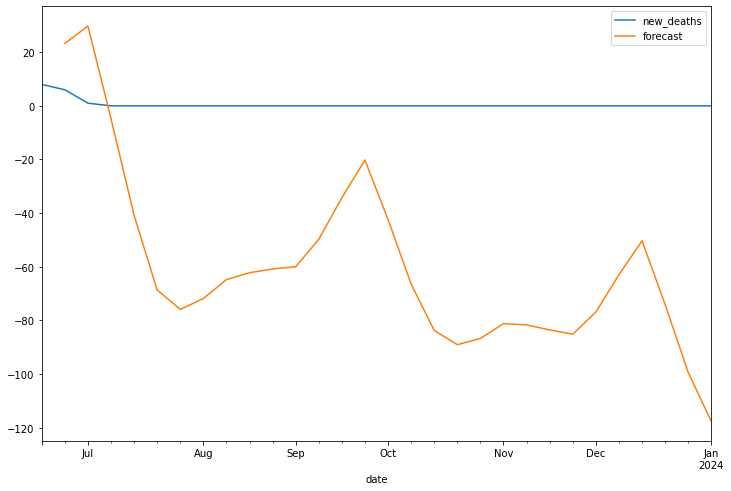

In [37]:
model=sm.tsa.statespace.SARIMAX(belgium_train['new_deaths'],order=(2, 1, 2),seasonal_order=(1,1,1,12))
results=model.fit()
belgium_test['forecast']=results.predict(start=173,end=202,dynamic=True)
belgium_test[['new_deaths','forecast']].plot(figsize=(12,8))



## autoARIMA

In [39]:
auto_model = auto_arima(belgium_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=12
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  172
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -971.322
Date:                Fri, 16 Feb 2024   AIC                           1948.644
Time:                        16:11:09   BIC                           1958.069
Sample:                    03-01-2020   HQIC                          1952.468
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1082      0.039     28.404      0.000       1.032       1.185
ar.L2         -0.5921      0.037    -15.946      0.000      -0.665      -0.519
sigma2      4983.0738    200.550     24.847      0.0

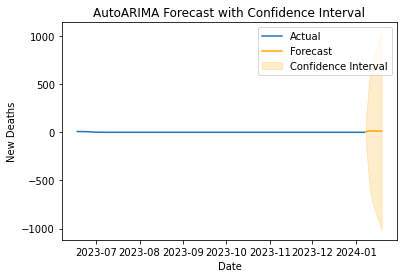

In [40]:
forecast_index = pd.date_range(belgium_test.index[-1], periods=n_periods + 1, freq=belgium_test.index.freq)[-n_periods:]

plt.plot(belgium_test.index, belgium_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

# Chile

## train/test split

In [57]:
chile = pd.read_csv('univariate_df_Chile.csv')
chile = chile.set_index('date')
chile.index = pd.to_datetime(chile.index)
chile = chile.drop('Unnamed: 0', axis=1)

In [59]:
chile.sort_index()
train_size = int(len(chile) * 0.8)
chile_train, chile_test = chile[0:train_size], belgium[train_size:]
chile_train=chile.iloc[:-30 ]
chile_test=chile.iloc[-30: ]
print(chile_train.shape, chile_test.shape)

(172, 1) (30, 1)


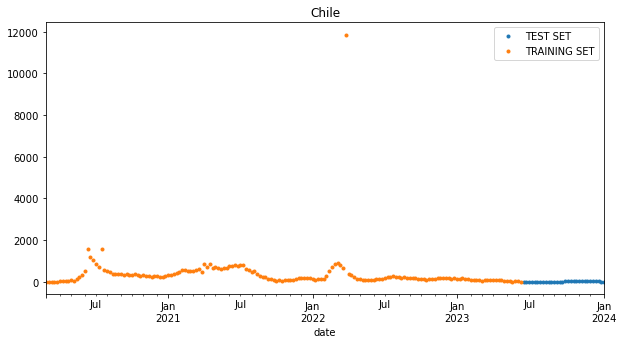

In [60]:
_ = chile_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(chile_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Chile', style='.')

## basic ARIMA (1,1,1)

In [61]:
model=ARIMA(chile_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1411.847
Date:                Fri, 16 Feb 2024   AIC                           2829.695
Time:                        16:54:42   BIC                           2839.120
Sample:                    03-01-2020   HQIC                          2833.519
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1040      0.085      1.224      0.221      -0.063       0.270
ma.L1         -0.9812      0.081    -12.129      0.000      -1.140      -0.823
sigma2      8.554e+05   1.95e+04     43.780      0.000    8.17e+05    8.94e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            130732.74
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            11.06
Prob(H) (two-sided):                  0.19   Kurtosis:                       136.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

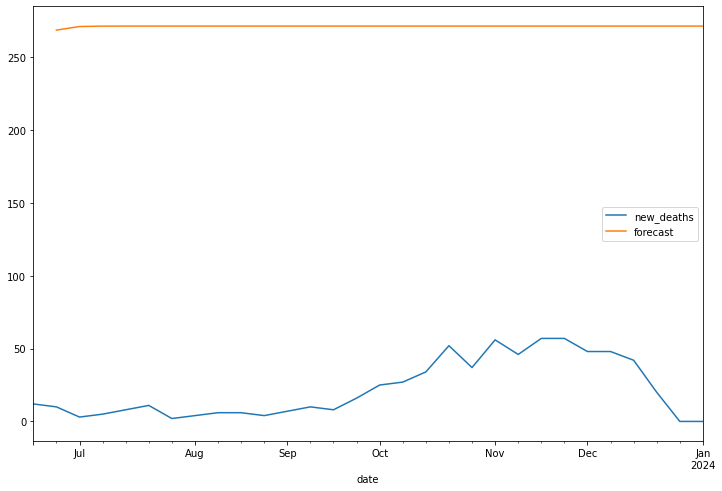

In [62]:
chile_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
chile_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search ARIMA

In [63]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(chile_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
1,1,2,2828.445151
0,1,1,2829.694691
4,2,1,2829.993025
2,1,3,2830.156264
5,2,2,2830.174612
8,3,1,2830.771639
9,3,2,2832.020292
12,4,1,2832.136251
3,1,4,2832.197361
13,4,2,2833.922400


In [64]:
model=ARIMA(chile_train['new_deaths'],order=(1,1,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1410.223
Date:                Fri, 16 Feb 2024   AIC                           2828.445
Time:                        16:55:02   BIC                           2841.012
Sample:                    03-01-2020   HQIC                          2833.544
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7931      0.286      2.769      0.006       0.232       1.355
ma.L1         -1.6775      0.304     -5.513      0.000      -2.274      -1.081
ma.L2          0.6775      0.305      2.219      0.026       0.079       1.276
sigma2      8.333e+05   6.28e-07   1.33e+12      0.000    8.33e+05    8.33e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):            132033.05
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            11.07
Prob(H) (two-sided):                  0.02   Kurtosis:                       137.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.36e+27. Standard errors may be unstable.
"""

## grid search SARIMA

In [71]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(chile_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86981D+00    |proj g|=  5.65779D-02

At iterate    5    f=  7.83707D+00    |proj g|=  4.44266D-03


 This problem is unconstrained.



At iterate   10    f=  7.83632D+00    |proj g|=  9.57413D-04

At iterate   15    f=  7.83628D+00    |proj g|=  4.33224D-04

At iterate   20    f=  7.83284D+00    |proj g|=  2.62277D-02

At iterate   25    f=  7.73723D+00    |proj g|=  9.42011D-02

At iterate   30    f=  7.72727D+00    |proj g|=  8.89036D-05

At iterate   35    f=  7.72727D+00    |proj g|=  5.31344D-04

At iterate   40    f=  7.72724D+00    |proj g|=  2.14028D-04

At iterate   45    f=  7.72723D+00    |proj g|=  5.58314D-05

At iterate   50    f=  7.72723D+00    |proj g|=  5.94154D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61   

 This problem is unconstrained.



At iterate    5    f=  7.83738D+00    |proj g|=  5.00282D-03

At iterate   10    f=  7.83672D+00    |proj g|=  5.69692D-04

At iterate   15    f=  7.83647D+00    |proj g|=  9.57857D-03

At iterate   20    f=  7.83564D+00    |proj g|=  2.49261D-03

At iterate   25    f=  7.83528D+00    |proj g|=  1.88148D-03

At iterate   30    f=  7.83509D+00    |proj g|=  1.72263D-03

At iterate   35    f=  7.81090D+00    |proj g|=  9.07792D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   40    f=  7.75297D+00    |proj g|=  3.59881D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     65      1     0     0   3.599D-02   7.753D+00
  F =   7.7529706602865485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.87021D+00    |proj g|=  4.67313D-02

At iterate    5    f=  7.83715D+00    |proj g|=  1.35357D-02

At iterate   10    f=  7.83613D+00    |proj g|=  5.36606D-04

At iterate   15    f=  7.83606D+00    |proj g|=  8.79453D-04

At iterate   20    f=  7.83591D+00    |proj g|=  5.51923D-03

At iterate   25    f=  7.81405D+00    |proj g|=  1.11080D-01

At iterate   30    f=  7.72783D+00    |proj g|=  4.21515D-02

At iterate   35    f=  7.72526D+00    |proj g|=  4.63212D-03

At iterate   40    f=  7.72472D+00    |proj g|=  7.14068D-03

At iterate   45    f=  7.72398D+00    |proj g|=  1.35474D-03

At iterate   50    f=  7.72390D+00    |proj g|=  5.94988D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.83690D+00    |proj g|=  6.85104D-03

At iterate   10    f=  7.83618D+00    |proj g|=  3.24892D-04

At iterate   15    f=  7.83609D+00    |proj g|=  3.04661D-03

At iterate   20    f=  7.83528D+00    |proj g|=  4.22720D-03

At iterate   25    f=  7.83388D+00    |proj g|=  4.25356D-03

At iterate   30    f=  7.83172D+00    |proj g|=  1.01702D-02

At iterate   35    f=  7.73618D+00    |proj g|=  5.38088D-02

At iterate   40    f=  7.72592D+00    |proj g|=  2.80187D-03

At iterate   45    f=  7.72524D+00    |proj g|=  2.85739D-03
  ys=-2.757E-06  -gs= 2.179E-06 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     87      1     1     0   8.454D-04   7.725D+00
  F =   7.7251189551977095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86169D+00    |proj g|=  5.90861D-02

At iterate    5    f=  7.83201D+00    |proj g|=  2.40248D-03

At iterate   10    f=  7.83191D+00    |proj g|=  9.11665D-04

At iterate   15    f=  7.82823D+00    |proj g|=  3.10080D-02

At iterate   20    f=  7.73347D+00    |proj g|=  2.60082D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     42      1     0     0   2.250D-03   7.733D+00
  F =   7.7327414494632576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83864D+00    |proj g|=  3.24050D-02

At iterate    5    f=  7.83248D+00    |proj g|=  3.87655D-03

At iterate   10    f=  7.83234D+00    |proj g|=  1.47975D-03

At iterate   15    f=  7.83153D+00    |proj g|=  6.27717D-03


LinAlgError: LU decomposition error.

In [72]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
0,1,1,1,1,2668.167490
2,1,1,2,1,2669.022604
3,1,1,2,2,2671.440921
4,1,2,1,1,2672.063059
1,1,1,1,2,2679.021907


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86981D+00    |proj g|=  5.65779D-02


 This problem is unconstrained.



At iterate    5    f=  7.83707D+00    |proj g|=  4.44266D-03

At iterate   10    f=  7.83632D+00    |proj g|=  9.57413D-04

At iterate   15    f=  7.83628D+00    |proj g|=  4.33224D-04

At iterate   20    f=  7.83284D+00    |proj g|=  2.62277D-02

At iterate   25    f=  7.73723D+00    |proj g|=  9.42011D-02

At iterate   30    f=  7.72727D+00    |proj g|=  8.89036D-05

At iterate   35    f=  7.72727D+00    |proj g|=  5.31344D-04

At iterate   40    f=  7.72724D+00    |proj g|=  2.14028D-04

At iterate   45    f=  7.72723D+00    |proj g|=  5.58314D-05

At iterate   50    f=  7.72723D+00    |proj g|=  5.94154D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<AxesSubplot:xlabel='date'>

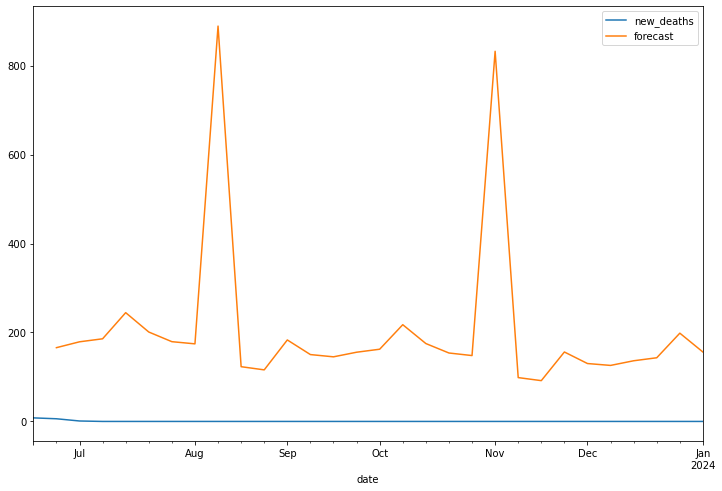

In [73]:
model=sm.tsa.statespace.SARIMAX(chile_train['new_deaths'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
belgium_test['forecast']=results.predict(start=173,end=202,dynamic=True)
belgium_test[['new_deaths','forecast']].plot(figsize=(12,8))

## autoARIMA

In [74]:
auto_model = auto_arima(chile_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=12
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  172
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1417.338
Date:                Fri, 16 Feb 2024   AIC                           2840.675
Time:                        17:02:42   BIC                           2850.118
Sample:                    03-01-2020   HQIC                          2844.506
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    338.8423    270.483      1.253      0.210    -191.295     868.979
ar.L1          0.1077      0.065      1.658      0.097      -0.020       0.235
sigma2      8.454e+05   3.93e+04     21.504      0.0

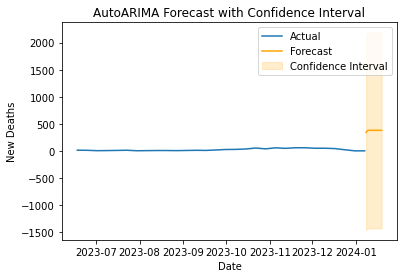

In [75]:
forecast_index = pd.date_range(chile_test.index[-1], periods=n_periods + 1, freq=chile_test.index.freq)[-n_periods:]

plt.plot(chile_test.index, chile_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

# Ireland

## train/test split

In [84]:
ireland = pd.read_csv('univariate_df_Ireland.csv')
ireland = ireland.set_index('date')
ireland.index = pd.to_datetime(ireland.index)
ireland = ireland.drop('Unnamed: 0', axis=1)

In [85]:
ireland.sort_index()
train_size = int(len(ireland) * 0.8)
ireland_train, ireland_test = ireland[0:train_size], ireland[train_size:]
ireland_train=ireland.iloc[:-30 ]
ireland_test=ireland.iloc[-30: ]
print(ireland_train.shape, ireland_test.shape)

(172, 1) (30, 1)


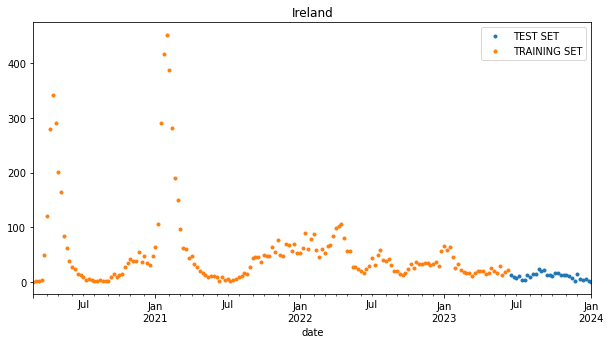

In [86]:
_ = ireland_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(ireland_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Ireland', style='.')

## basic ARIMA (1,1,1)

In [87]:
model=ARIMA(ireland_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -787.574
Date:                Fri, 16 Feb 2024   AIC                           1581.149
Time:                        17:11:41   BIC                           1590.574
Sample:                    03-01-2020   HQIC                          1584.973
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4382      0.069      6.387      0.000       0.304       0.573
ma.L1          0.2279      0.078      2.905      0.004       0.074       0.382
sigma2       584.5521     30.129     19.401      0.000     525.500     643.605
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1405.91
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             1.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

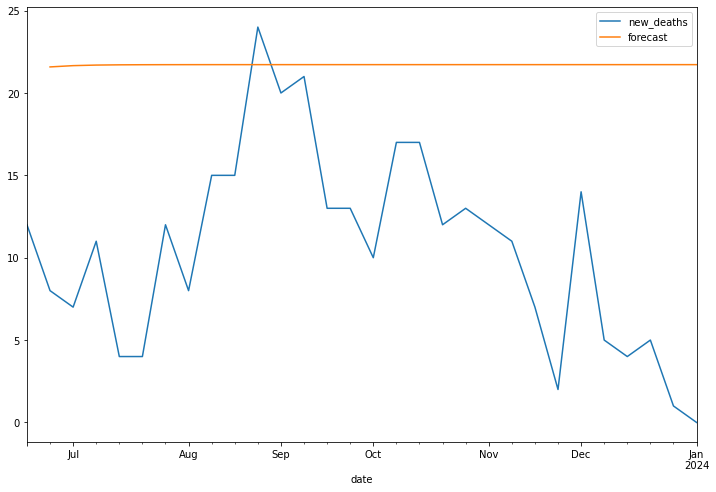

In [88]:
ireland_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
ireland_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search ARIMA

In [89]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(ireland_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
4,2,1,1560.643578
15,4,4,1561.226801
9,3,2,1561.573956
8,3,1,1562.133925
5,2,2,1562.216783
13,4,2,1562.265406
14,4,3,1562.293245
10,3,3,1562.355769
12,4,1,1563.451130
6,2,3,1563.717480


In [90]:
model=ARIMA(ireland_train['new_deaths'],order=(2,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -776.322
Date:                Fri, 16 Feb 2024   AIC                           1560.644
Time:                        17:12:37   BIC                           1573.210
Sample:                    03-01-2020   HQIC                          1565.743
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5076      0.039     38.656      0.000       1.431       1.584
ar.L2         -0.6450      0.043    -15.089      0.000      -0.729      -0.561
ma.L1         -0.9936      0.086    -11.570      0.000      -1.162      -0.825
sigma2       504.3075     41.671     12.102      0.000     422.635     585.980
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              2942.58
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             3.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

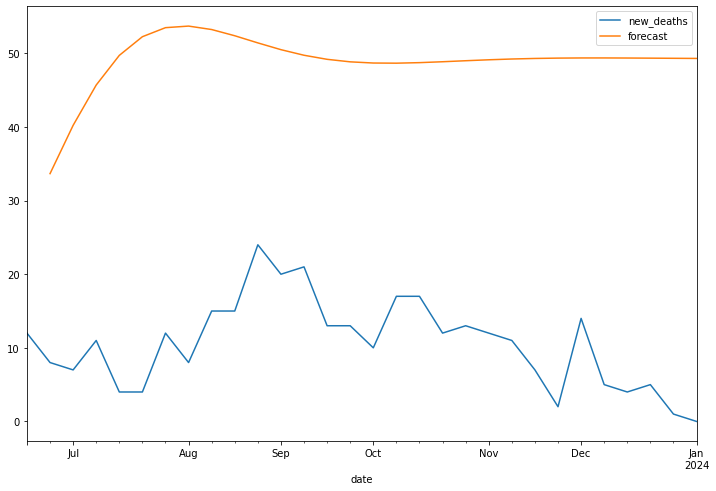

In [91]:
ireland_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
ireland_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search SARIMA

In [92]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(ireland_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.41619D+00    |proj g|=  5.07317D-02


 This problem is unconstrained.



At iterate    5    f=  4.39276D+00    |proj g|=  1.10213D-02

At iterate   10    f=  4.34789D+00    |proj g|=  4.63991D-03

At iterate   15    f=  4.34780D+00    |proj g|=  7.57615D-04

At iterate   20    f=  4.34719D+00    |proj g|=  3.22167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     40      1     0     0   3.184D-05   4.347D+00
  F =   4.3471873267297818     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  4.39399D+00    |proj g|=  1.23217D-02

At iterate   10    f=  4.34788D+00    |proj g|=  3.30424D-03

At iterate   15    f=  4.34786D+00    |proj g|=  8.63795D-04

At iterate   20    f=  4.34749D+00    |proj g|=  2.62605D-04

At iterate   25    f=  4.34746D+00    |proj g|=  1.28567D-03

At iterate   30    f=  4.34740D+00    |proj g|=  6.27909D-04

At iterate   35    f=  4.34739D+00    |proj g|=  1.05350D-03

At iterate   40    f=  4.34739D+00    |proj g|=  2.19456D-04

At iterate   45    f=  4.34739D+00    |proj g|=  3.74402D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     59   

 This problem is unconstrained.



At iterate    5    f=  4.39397D+00    |proj g|=  2.31136D-02

At iterate   10    f=  4.37852D+00    |proj g|=  6.54553D-02

At iterate   15    f=  4.34724D+00    |proj g|=  2.68056D-03

At iterate   20    f=  4.34713D+00    |proj g|=  4.02405D-03

At iterate   25    f=  4.34699D+00    |proj g|=  6.47904D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   7.117D-06   4.347D+00
  F =   4.3469899651914936     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.40628D+00    |proj g|=  4.50061D-02

At iterate    5    f=  4.39448D+00    |proj g|=  1.07175D-02

At iterate   10    f=  4.34824D+00    |proj g|=  8.94292D-03

At iterate   15    f=  4.34742D+00    |proj g|=  3.29396D-04

At iterate   20    f=  4.34726D+00    |proj g|=  5.69559D-03

At iterate   25    f=  4.34708D+00    |proj g|=  5.00765D-03

At iterate   30    f=  4.34697D+00    |proj g|=  1.67752D-04

At iterate   35    f=  4.34694D+00    |proj g|=  3.27404D-04

At iterate   40    f=  4.34693D+00    |proj g|=  3.73243D-04

At iterate   45    f=  4.34693D+00    |proj g|=  7.13714D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  4.37499D+00    |proj g|=  9.30636D-03

At iterate   10    f=  4.35281D+00    |proj g|=  7.38036D-02

At iterate   15    f=  4.34464D+00    |proj g|=  2.60493D-03

At iterate   20    f=  4.34464D+00    |proj g|=  4.39475D-04
  ys=-9.037E-05  -gs= 1.305E-04 BFGS update SKIPPED

At iterate   25    f=  4.34400D+00    |proj g|=  1.14838D-02

At iterate   30    f=  4.34389D+00    |proj g|=  1.15438D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     49      1     1     0   7.217D-06   4.344D+00
  F =   4.3438902015859560     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 This problem is unconstrained.



At iterate    5    f=  4.37521D+00    |proj g|=  9.44479D-03

At iterate   10    f=  4.35820D+00    |proj g|=  1.98785D-02

At iterate   15    f=  4.34458D+00    |proj g|=  3.64655D-03

At iterate   20    f=  4.34431D+00    |proj g|=  3.50713D-04

At iterate   25    f=  4.34431D+00    |proj g|=  7.50947D-05

At iterate   30    f=  4.34429D+00    |proj g|=  2.84164D-03

At iterate   35    f=  4.34398D+00    |proj g|=  6.54744D-03

At iterate   40    f=  4.34369D+00    |proj g|=  3.24165D-03

At iterate   45    f=  4.34354D+00    |proj g|=  5.31286D-04

At iterate   50    f=  4.34354D+00    |proj g|=  2.86012D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.37587D+00    |proj g|=  2.58175D-02

At iterate   10    f=  4.37145D+00    |proj g|=  1.34748D-02

At iterate   15    f=  4.34848D+00    |proj g|=  3.97998D-02

At iterate   20    f=  4.34403D+00    |proj g|=  1.27989D-03

At iterate   25    f=  4.34364D+00    |proj g|=  1.01537D-02

At iterate   30    f=  4.34350D+00    |proj g|=  8.16190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     37      1     0     0   1.851D-05   4.343D+00
  F =   4.3434952518229535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  4.37510D+00    |proj g|=  1.03808D-02

At iterate   10    f=  4.35899D+00    |proj g|=  2.65705D-02

At iterate   15    f=  4.34404D+00    |proj g|=  1.76178D-02

At iterate   20    f=  4.34340D+00    |proj g|=  1.48917D-03

At iterate   25    f=  4.34335D+00    |proj g|=  2.62599D-03

At iterate   30    f=  4.34290D+00    |proj g|=  3.91521D-03

At iterate   35    f=  4.34281D+00    |proj g|=  4.81971D-03

At iterate   40    f=  4.34230D+00    |proj g|=  2.22709D-03

At iterate   45    f=  4.34227D+00    |proj g|=  2.39403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     56   

 This problem is unconstrained.



At iterate    5    f=  4.35331D+00    |proj g|=  1.18498D-02

At iterate   10    f=  4.30273D+00    |proj g|=  2.47369D-03

At iterate   15    f=  4.29822D+00    |proj g|=  6.85957D-03

At iterate   20    f=  4.29591D+00    |proj g|=  1.03713D-03

At iterate   25    f=  4.29563D+00    |proj g|=  5.81343D-04

At iterate   30    f=  4.29446D+00    |proj g|=  4.55087D-04

At iterate   35    f=  4.29446D+00    |proj g|=  1.42188D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     47      1     0     0   1.422D-06   4.294D+00
  F =   4.2944617416383890     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  4.36044D+00    |proj g|=  2.09225D-02

At iterate   10    f=  4.30151D+00    |proj g|=  9.16350D-03

At iterate   15    f=  4.29608D+00    |proj g|=  4.44391D-03

At iterate   20    f=  4.29415D+00    |proj g|=  2.36135D-03

At iterate   25    f=  4.29394D+00    |proj g|=  1.37083D-03

At iterate   30    f=  4.29388D+00    |proj g|=  8.24034D-04

At iterate   35    f=  4.29386D+00    |proj g|=  2.97963D-04

At iterate   40    f=  4.29386D+00    |proj g|=  1.25254D-04

At iterate   45    f=  4.29386D+00    |proj g|=  6.40614D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     52   

 This problem is unconstrained.



At iterate    5    f=  4.35838D+00    |proj g|=  1.19976D-02

At iterate   10    f=  4.31627D+00    |proj g|=  6.98163D-02

At iterate   15    f=  4.30078D+00    |proj g|=  2.98405D-03

At iterate   20    f=  4.29464D+00    |proj g|=  1.00628D-02

At iterate   25    f=  4.29037D+00    |proj g|=  1.65696D-02

At iterate   30    f=  4.28991D+00    |proj g|=  2.35744D-04

At iterate   35    f=  4.28987D+00    |proj g|=  3.04320D-03

At iterate   40    f=  4.28970D+00    |proj g|=  7.60218D-04

At iterate   45    f=  4.28968D+00    |proj g|=  2.90366D-04

At iterate   50    f=  4.28968D+00    |proj g|=  8.42276D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.34941D+00    |proj g|=  4.47301D-02

At iterate   10    f=  4.29767D+00    |proj g|=  4.69732D-03

At iterate   15    f=  4.29708D+00    |proj g|=  5.08455D-03

At iterate   20    f=  4.29258D+00    |proj g|=  5.45425D-03

At iterate   25    f=  4.29110D+00    |proj g|=  1.70261D-03

At iterate   30    f=  4.29084D+00    |proj g|=  2.73205D-03

At iterate   35    f=  4.28981D+00    |proj g|=  1.78846D-03

At iterate   40    f=  4.28964D+00    |proj g|=  1.60680D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     53      1     0     0   5.932D-06   4.290D+00
  F =   4.28964424130

 This problem is unconstrained.



At iterate    5    f=  4.34169D+00    |proj g|=  1.02607D-02

At iterate   10    f=  4.31691D+00    |proj g|=  2.47392D-02

At iterate   15    f=  4.29537D+00    |proj g|=  3.61401D-02

At iterate   20    f=  4.29289D+00    |proj g|=  2.27534D-03

At iterate   25    f=  4.29219D+00    |proj g|=  8.29706D-03

At iterate   30    f=  4.29185D+00    |proj g|=  2.49571D-03

At iterate   35    f=  4.29147D+00    |proj g|=  6.78649D-04

At iterate   40    f=  4.29142D+00    |proj g|=  6.09308D-04

At iterate   45    f=  4.29141D+00    |proj g|=  7.71126D-04

At iterate   50    f=  4.29141D+00    |proj g|=  8.67621D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.34431D+00    |proj g|=  1.27279D-02

At iterate   10    f=  4.31566D+00    |proj g|=  2.09977D-02

At iterate   15    f=  4.29465D+00    |proj g|=  1.52946D-02

At iterate   20    f=  4.29306D+00    |proj g|=  1.05258D-02

At iterate   25    f=  4.29134D+00    |proj g|=  1.34065D-03

At iterate   30    f=  4.29118D+00    |proj g|=  1.11392D-03

At iterate   35    f=  4.29096D+00    |proj g|=  6.88860D-04

At iterate   40    f=  4.29092D+00    |proj g|=  4.04477D-04

At iterate   45    f=  4.29092D+00    |proj g|=  2.06188D-04

At iterate   50    f=  4.29092D+00    |proj g|=  2.84428D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.33947D+00    |proj g|=  1.45744D-02

At iterate   10    f=  4.32248D+00    |proj g|=  3.71209D-02

At iterate   15    f=  4.29534D+00    |proj g|=  3.45087D-02

At iterate   20    f=  4.28823D+00    |proj g|=  3.75788D-03

At iterate   25    f=  4.28816D+00    |proj g|=  4.94572D-03

At iterate   30    f=  4.28740D+00    |proj g|=  3.30956D-03

At iterate   35    f=  4.28724D+00    |proj g|=  9.29746D-04

At iterate   40    f=  4.28721D+00    |proj g|=  3.31769D-04

At iterate   45    f=  4.28720D+00    |proj g|=  6.34729D-04

At iterate   50    f=  4.28720D+00    |proj g|=  6.98438D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.33725D+00    |proj g|=  1.43810D-02

At iterate   10    f=  4.31443D+00    |proj g|=  2.45493D-02

At iterate   15    f=  4.29162D+00    |proj g|=  2.55944D-02

At iterate   20    f=  4.28944D+00    |proj g|=  1.88428D-03

At iterate   25    f=  4.28881D+00    |proj g|=  9.77446D-03

At iterate   30    f=  4.28833D+00    |proj g|=  4.64434D-03

At iterate   35    f=  4.28724D+00    |proj g|=  1.44190D-03

At iterate   40    f=  4.28716D+00    |proj g|=  5.20990D-04

At iterate   45    f=  4.28706D+00    |proj g|=  5.39116D-04

At iterate   50    f=  4.28701D+00    |proj g|=  1.12653D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [93]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
8,2,1,1,1,1489.294839
10,2,1,2,1,1489.648558
12,2,2,1,1,1490.244633
14,2,2,2,1,1490.797608
9,2,1,1,2,1491.088038
11,2,1,2,2,1491.637619
13,2,2,1,2,1492.075298
15,2,2,2,2,1492.731908
0,1,1,1,1,1505.432440
4,1,2,1,1,1506.298229


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38383D+00    |proj g|=  3.83065D-02

At iterate    5    f=  4.35331D+00    |proj g|=  1.18498D-02

At iterate   10    f=  4.30273D+00    |proj g|=  2.47369D-03

At iterate   15    f=  4.29822D+00    |proj g|=  6.85957D-03

At iterate   20    f=  4.29591D+00    |proj g|=  1.03713D-03

At iterate   25    f=  4.29563D+00    |proj g|=  5.81343D-04

At iterate   30    f=  4.29446D+00    |proj g|=  4.55087D-04

At iterate   35    f=  4.29446D+00    |proj g|=  1.42188D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<AxesSubplot:xlabel='date'>

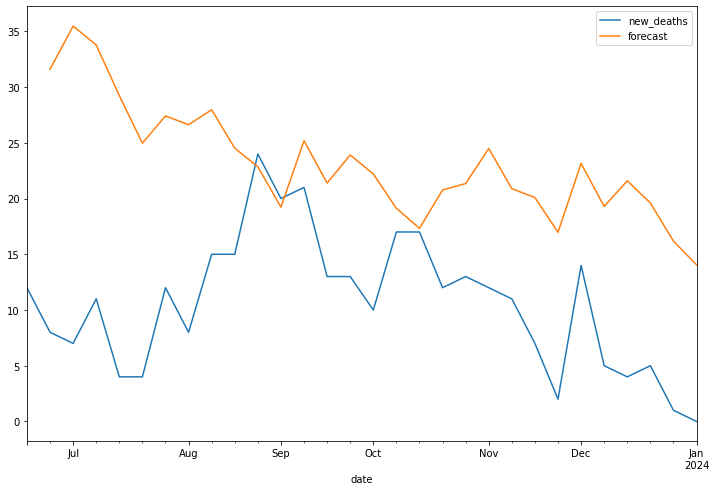

In [95]:
model=sm.tsa.statespace.SARIMAX(ireland_train['new_deaths'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
ireland_test['forecast']=results.predict(start=173,end=202,dynamic=True)
ireland_test[['new_deaths','forecast']].plot(figsize=(12,8))

## autoARIMA

In [96]:
auto_model = auto_arima(ireland_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=12
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  172
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -779.748
Date:                Fri, 16 Feb 2024   AIC                           1567.496
Time:                        17:16:53   BIC                           1580.086
Sample:                    03-01-2020   HQIC                          1572.604
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.3063      3.446      2.120      0.034       0.553      14.060
ar.L1          1.5060      0.042     35.728      0.000       1.423       1.589
ar.L2         -0.6465      0.043    -15.157      0.0

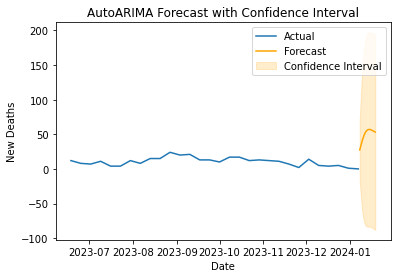

In [97]:
forecast_index = pd.date_range(ireland_test.index[-1], periods=n_periods + 1, freq=ireland_test.index.freq)[-n_periods:]

plt.plot(ireland_test.index, ireland_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

# Israel

## train/test split

In [98]:
israel = pd.read_csv('univariate_df_Israel.csv')
israel = israel.set_index('date')
israel.index = pd.to_datetime(israel.index)
israel = israel.drop('Unnamed: 0', axis=1)
israel.sort_index()
train_size = int(len(israel) * 0.8)
israel_train, israel_test = israel[0:train_size], israel[train_size:]
israel_train=israel.iloc[:-30 ]
israel_test=israel.iloc[-30: ]
print(israel_train.shape, israel_test.shape)

(172, 1) (30, 1)


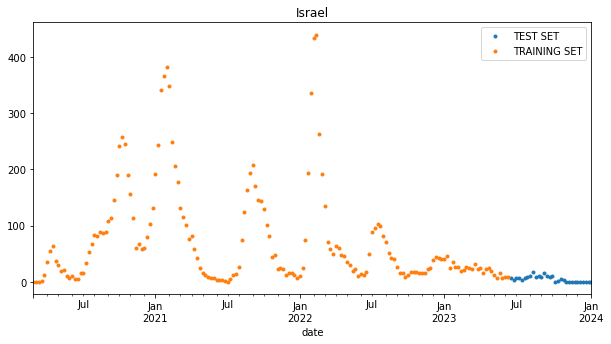

In [99]:
_ = israel_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(israel_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Israel', style='.')

## basic ARIMA (1,1,1)

In [100]:
model=ARIMA(israel_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -784.303
Date:                Fri, 16 Feb 2024   AIC                           1574.606
Time:                        17:18:09   BIC                           1584.031
Sample:                    03-01-2020   HQIC                          1578.431
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5509      0.074      7.451      0.000       0.406       0.696
ma.L1          0.1529      0.092      1.656      0.098      -0.028       0.334
sigma2       562.3141     32.011     17.566      0.000     499.573     625.055
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              2026.51
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -1.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

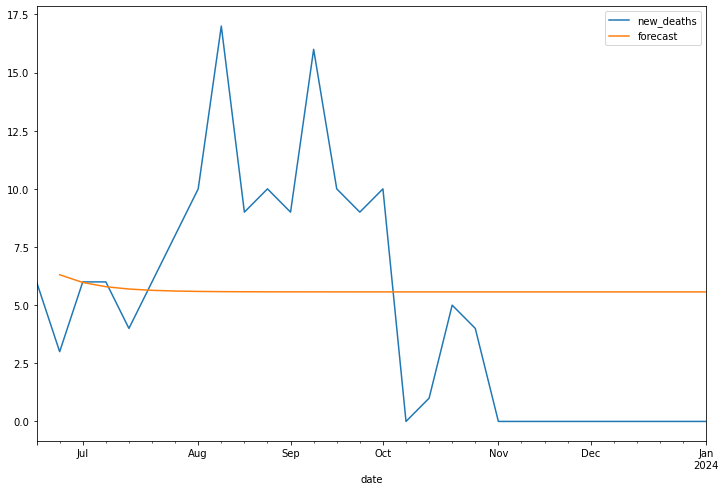

In [101]:
israel_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
israel_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search ARIMA

In [102]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(israel_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
7,2,4,1555.205736
3,1,4,1555.652584
4,2,1,1555.729115
14,4,3,1556.584781
11,3,4,1556.705566
6,2,3,1557.323670
15,4,4,1557.623423
8,3,1,1557.726216
5,2,2,1557.726940
10,3,3,1558.147409


In [103]:
model=ARIMA(israel_train['new_deaths'],order=(2,1,4))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -770.603
Date:                Fri, 16 Feb 2024   AIC                           1555.206
Time:                        17:19:46   BIC                           1577.197
Sample:                    03-01-2020   HQIC                          1564.129
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2084      0.233      5.190      0.000       0.752       1.665
ar.L2         -0.3773      0.233     -1.619      0.106      -0.834       0.080
ma.L1         -0.6003      0.261     -2.302      0.021      -1.111      -0.089
ma.L2         -0.0206      0.185     -0.112      0.911      -0.382       0.341
ma.L3         -0.1114      0.097     -1.144      0.253      -0.302       0.079
ma.L4         -0.2488      0.159     -1.564      0.118      -0.561       0.063
sigma2       473.0512     34.571     13.683      0.000     405.293     540.809
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               770.37
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

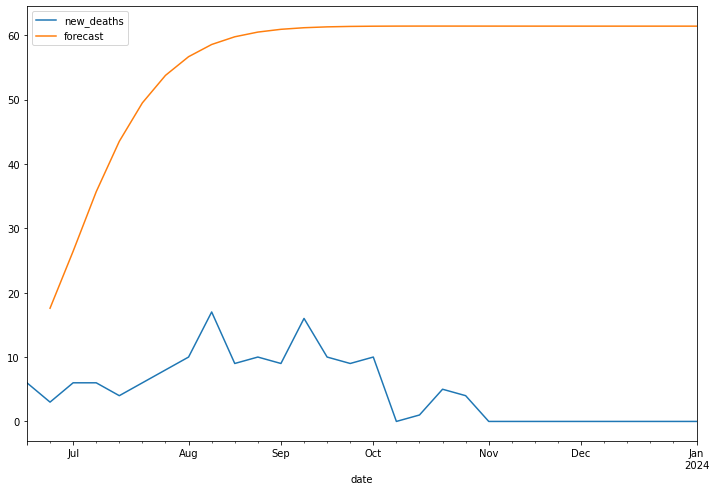

In [104]:
israel_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
israel_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search SARIMA

In [105]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(israel_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.47173D+00    |proj g|=  6.12492D-02


 This problem is unconstrained.



At iterate    5    f=  4.43949D+00    |proj g|=  1.79105D-02

At iterate   10    f=  4.36620D+00    |proj g|=  1.59062D-01

At iterate   15    f=  4.34831D+00    |proj g|=  4.73638D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   3.137D-05   4.348D+00
  F =   4.3483078745572197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44848D+00    |proj g|=  4.65419D-02


 This problem is unconstrained.



At iterate    5    f=  4.43415D+00    |proj g|=  1.40270D-02

At iterate   10    f=  4.35736D+00    |proj g|=  1.01155D-01

At iterate   15    f=  4.34697D+00    |proj g|=  8.11136D-03

At iterate   20    f=  4.34622D+00    |proj g|=  1.88941D-04

At iterate   25    f=  4.34606D+00    |proj g|=  3.50308D-03

At iterate   30    f=  4.34589D+00    |proj g|=  1.69471D-04

At iterate   35    f=  4.34589D+00    |proj g|=  1.00932D-04

At iterate   40    f=  4.34588D+00    |proj g|=  7.36141D-04

At iterate   45    f=  4.34587D+00    |proj g|=  2.65171D-04

At iterate   50    f=  4.34587D+00    |proj g|=  1.14958D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.43952D+00    |proj g|=  5.55073D-02

At iterate   10    f=  4.42449D+00    |proj g|=  3.48860D-02

At iterate   15    f=  4.35904D+00    |proj g|=  5.74983D-02

At iterate   20    f=  4.34440D+00    |proj g|=  4.82024D-03

At iterate   25    f=  4.34436D+00    |proj g|=  4.31500D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     31      1     0     0   4.315D-05   4.344D+00
  F =   4.3443570102691966     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  4.43791D+00    |proj g|=  1.23850D-02

At iterate   10    f=  4.35905D+00    |proj g|=  6.04709D-02

At iterate   15    f=  4.34691D+00    |proj g|=  4.96279D-03

At iterate   20    f=  4.34619D+00    |proj g|=  4.43569D-04

At iterate   25    f=  4.34617D+00    |proj g|=  7.71190D-04

At iterate   30    f=  4.34613D+00    |proj g|=  4.22086D-03

At iterate   35    f=  4.34497D+00    |proj g|=  1.23604D-02

At iterate   40    f=  4.34433D+00    |proj g|=  6.00514D-03

At iterate   45    f=  4.34421D+00    |proj g|=  1.14916D-03

At iterate   50    f=  4.34419D+00    |proj g|=  5.31459D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.43420D+00    |proj g|=  1.21183D-02

At iterate   10    f=  4.34396D+00    |proj g|=  6.08137D-02

At iterate   15    f=  4.33717D+00    |proj g|=  7.37846D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     21      1     0     0   1.810D-05   4.337D+00
  F =   4.3371707973844016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44381D+00    |proj g|=  5.39058D-02


 This problem is unconstrained.



At iterate    5    f=  4.43149D+00    |proj g|=  1.28011D-02

At iterate   10    f=  4.33833D+00    |proj g|=  2.01306D-02

At iterate   15    f=  4.33616D+00    |proj g|=  7.66331D-03

At iterate   20    f=  4.33608D+00    |proj g|=  1.69517D-04

At iterate   25    f=  4.33605D+00    |proj g|=  2.47051D-03

At iterate   30    f=  4.33575D+00    |proj g|=  4.77254D-03

At iterate   35    f=  4.33566D+00    |proj g|=  1.37651D-04

At iterate   40    f=  4.33566D+00    |proj g|=  1.97726D-03

At iterate   45    f=  4.33563D+00    |proj g|=  1.79102D-03

At iterate   50    f=  4.33562D+00    |proj g|=  2.50286D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.44399D+00    |proj g|=  8.03761D-02

At iterate   10    f=  4.41034D+00    |proj g|=  3.86495D-02

At iterate   15    f=  4.34235D+00    |proj g|=  3.19028D-02

At iterate   20    f=  4.33496D+00    |proj g|=  2.24730D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     26      1     0     0   1.129D-05   4.335D+00
  F =   4.3349634325642397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  4.43213D+00    |proj g|=  1.26448D-02

At iterate   10    f=  4.36206D+00    |proj g|=  4.81716D-02

At iterate   15    f=  4.33649D+00    |proj g|=  1.12384D-02

At iterate   20    f=  4.33598D+00    |proj g|=  1.46349D-04

At iterate   25    f=  4.33597D+00    |proj g|=  3.51703D-03

At iterate   30    f=  4.33580D+00    |proj g|=  9.45839D-04

At iterate   35    f=  4.33578D+00    |proj g|=  3.33965D-03

At iterate   40    f=  4.33570D+00    |proj g|=  3.37106D-03

At iterate   45    f=  4.33505D+00    |proj g|=  1.02110D-02

At iterate   50    f=  4.33492D+00    |proj g|=  9.34511D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.43920D+00    |proj g|=  2.32921D-02

At iterate   10    f=  4.42147D+00    |proj g|=  3.59437D-02

At iterate   15    f=  4.35073D+00    |proj g|=  4.22412D-03

At iterate   20    f=  4.35045D+00    |proj g|=  2.47924D-02

At iterate   25    f=  4.30565D+00    |proj g|=  2.72251D-02

At iterate   30    f=  4.29839D+00    |proj g|=  2.56304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     46      1     0     0   9.741D-06   4.298D+00
  F =   4.2983235263014237     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  4.43251D+00    |proj g|=  1.19086D-02

At iterate   10    f=  4.40388D+00    |proj g|=  8.36798D-02

At iterate   15    f=  4.33911D+00    |proj g|=  2.21315D-02

At iterate   20    f=  4.30588D+00    |proj g|=  1.68301D-02

At iterate   25    f=  4.29730D+00    |proj g|=  1.09849D-03

At iterate   30    f=  4.29725D+00    |proj g|=  7.59019D-05

At iterate   35    f=  4.29685D+00    |proj g|=  1.95555D-03

At iterate   40    f=  4.29604D+00    |proj g|=  2.84758D-03

At iterate   45    f=  4.29596D+00    |proj g|=  2.60645D-04

At iterate   50    f=  4.29589D+00    |proj g|=  1.68061D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.45505D+00    |proj g|=  2.78120D-02

At iterate   10    f=  4.42498D+00    |proj g|=  3.41046D-02

At iterate   15    f=  4.38029D+00    |proj g|=  7.45839D-02

At iterate   20    f=  4.34654D+00    |proj g|=  4.23624D-03

At iterate   25    f=  4.34651D+00    |proj g|=  1.18708D-03

At iterate   30    f=  4.34650D+00    |proj g|=  2.70367D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     37      1     0     0   2.276D-05   4.347D+00
  F =   4.3465016768702993     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  4.43488D+00    |proj g|=  2.22522D-02

At iterate   10    f=  4.42115D+00    |proj g|=  1.24516D-02

At iterate   15    f=  4.34984D+00    |proj g|=  1.61265D-02

At iterate   20    f=  4.31135D+00    |proj g|=  4.82074D-02

At iterate   25    f=  4.30011D+00    |proj g|=  1.95390D-02

At iterate   30    f=  4.29678D+00    |proj g|=  1.47744D-03

At iterate   35    f=  4.29675D+00    |proj g|=  1.04087D-04

At iterate   40    f=  4.29675D+00    |proj g|=  5.32245D-04

At iterate   45    f=  4.29667D+00    |proj g|=  5.56787D-03

At iterate   50    f=  4.29605D+00    |proj g|=  7.41761D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.41705D+00    |proj g|=  1.24067D-02

At iterate   10    f=  4.38419D+00    |proj g|=  5.20079D-02

At iterate   15    f=  4.32617D+00    |proj g|=  3.85690D-02

At iterate   20    f=  4.29797D+00    |proj g|=  4.30106D-03

At iterate   25    f=  4.29772D+00    |proj g|=  8.68451D-03

At iterate   30    f=  4.29737D+00    |proj g|=  2.98898D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   6.435D-05   4.297D+00
  F =   4.2973679931727036     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  4.41282D+00    |proj g|=  1.81651D-02

At iterate   10    f=  4.34101D+00    |proj g|=  4.30309D-02

At iterate   15    f=  4.30227D+00    |proj g|=  2.03185D-02

At iterate   20    f=  4.29600D+00    |proj g|=  2.30062D-03

At iterate   25    f=  4.29563D+00    |proj g|=  4.82443D-04

At iterate   30    f=  4.29511D+00    |proj g|=  1.98170D-02

At iterate   35    f=  4.29459D+00    |proj g|=  1.26356D-03

At iterate   40    f=  4.29456D+00    |proj g|=  2.34679D-04

At iterate   45    f=  4.29455D+00    |proj g|=  1.11249D-03

At iterate   50    f=  4.29450D+00    |proj g|=  2.46103D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.43329D+00    |proj g|=  9.34824D-02

At iterate   10    f=  4.40074D+00    |proj g|=  1.29379D-02

At iterate   15    f=  4.33519D+00    |proj g|=  6.62172D-02

At iterate   20    f=  4.32577D+00    |proj g|=  1.01903D-02

At iterate   25    f=  4.30113D+00    |proj g|=  2.04810D-02

At iterate   30    f=  4.29896D+00    |proj g|=  5.56421D-04

At iterate   35    f=  4.29842D+00    |proj g|=  2.55280D-02

At iterate   40    f=  4.29546D+00    |proj g|=  1.16496D-02

At iterate   45    f=  4.29525D+00    |proj g|=  5.00782D-04

At iterate   50    f=  4.29525D+00    |proj g|=  2.44263D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.41330D+00    |proj g|=  1.32579D-02

At iterate   10    f=  4.36836D+00    |proj g|=  3.96725D-02

At iterate   15    f=  4.34100D+00    |proj g|=  1.81074D-02

At iterate   20    f=  4.29930D+00    |proj g|=  3.16427D-02

At iterate   25    f=  4.29647D+00    |proj g|=  7.52933D-03

At iterate   30    f=  4.29533D+00    |proj g|=  6.22042D-04

At iterate   35    f=  4.29523D+00    |proj g|=  4.55788D-03

At iterate   40    f=  4.29504D+00    |proj g|=  1.61496D-03

At iterate   45    f=  4.29448D+00    |proj g|=  5.29167D-03

At iterate   50    f=  4.29428D+00    |proj g|=  9.82299D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [106]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
8,2,1,1,1,1490.623293
9,2,1,1,2,1491.787327
12,2,2,1,1,1492.294590
13,2,2,1,2,1493.306830
14,2,2,2,1,1493.566687
11,2,1,2,2,1493.840841
15,2,2,2,2,1495.230798
4,1,2,1,1,1503.986754
6,1,2,2,1,1505.227421
5,1,2,1,2,1505.453023


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64047D+00    |proj g|=  5.77114D-01

At iterate    5    f=  4.43920D+00    |proj g|=  2.32921D-02

At iterate   10    f=  4.42147D+00    |proj g|=  3.59437D-02

At iterate   15    f=  4.35073D+00    |proj g|=  4.22412D-03

At iterate   20    f=  4.35045D+00    |proj g|=  2.47924D-02

At iterate   25    f=  4.30565D+00    |proj g|=  2.72251D-02

At iterate   30    f=  4.29839D+00    |proj g|=  2.56304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

<AxesSubplot:xlabel='date'>

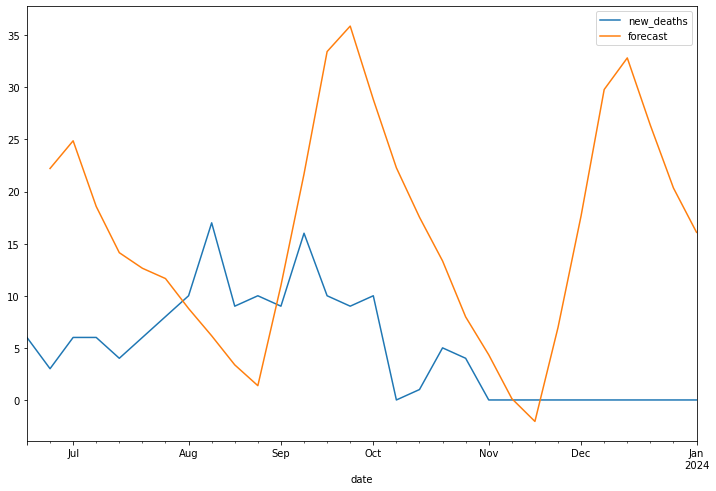

In [108]:
model=sm.tsa.statespace.SARIMAX(israel_train['new_deaths'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
israel_test['forecast']=results.predict(start=173,end=202,dynamic=True)
israel_test[['new_deaths','forecast']].plot(figsize=(12,8))

## autoARIMA

In [109]:
auto_model = auto_arima(israel_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=12
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  172
Model:               SARIMAX(2, 0, 3)   Log Likelihood                -774.487
Date:                Fri, 16 Feb 2024   AIC                           1562.973
Time:                        17:22:45   BIC                           1585.006
Sample:                    03-01-2020   HQIC                          1571.912
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.0557      6.904      1.746      0.081      -1.476      25.587
ar.L1          1.2159      0.213      5.708      0.000       0.798       1.633
ar.L2         -0.3878      0.202     -1.917      0.0

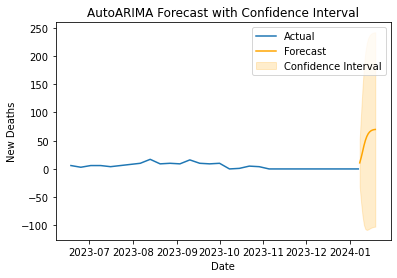

In [110]:
forecast_index = pd.date_range(israel_test.index[-1], periods=n_periods + 1, freq=israel_test.index.freq)[-n_periods:]

plt.plot(israel_test.index, israel_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

# Italy

## train/test split

In [111]:
italy = pd.read_csv('univariate_df_Italy.csv')
italy = italy.set_index('date')
italy.index = pd.to_datetime(italy.index)
italy = italy.drop('Unnamed: 0', axis=1)
italy.sort_index()
train_size = int(len(italy) * 0.8)
italy_train, italy_test = italy[0:train_size], italy[train_size:]
italy_train=italy.iloc[:-30 ]
italy_test=italy.iloc[-30: ]
print(italy_train.shape, italy_test.shape)

(172, 1) (30, 1)


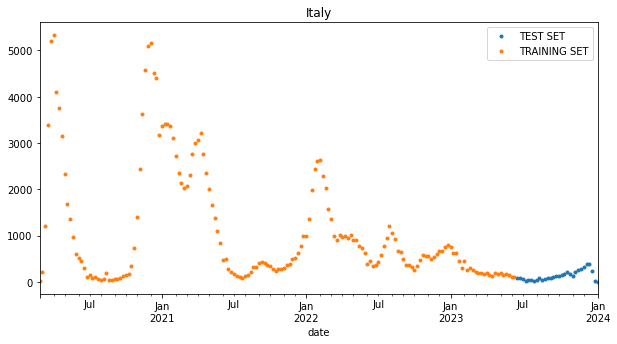

In [112]:
_ = italy_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(italy_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Italy', style='.')

## basic ARIMA (1,1,1)

In [113]:
model=ARIMA(italy_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1202.708
Date:                Fri, 16 Feb 2024   AIC                           2411.416
Time:                        17:23:54   BIC                           2420.841
Sample:                    03-01-2020   HQIC                          2415.241
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5655      0.042     13.454      0.000       0.483       0.648
ma.L1          0.1595      0.047      3.380      0.001       0.067       0.252
sigma2      7.506e+04   3462.614     21.678      0.000    6.83e+04    8.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               671.36
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

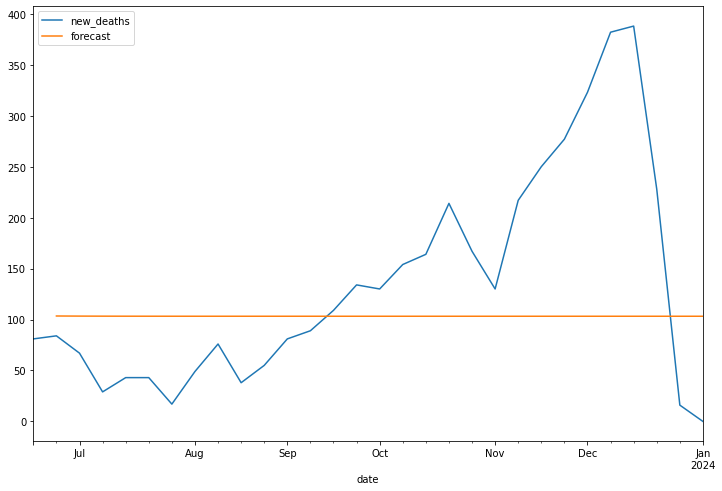

In [114]:
italy_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
italy_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search ARIMA

In [115]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(italy_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
4,2,1,2401.486668
12,4,1,2401.705486
6,2,3,2402.136690
8,3,1,2402.142492
10,3,3,2403.610834
9,3,2,2404.464477
14,4,3,2404.797624
11,3,4,2405.703009
13,4,2,2406.011599
1,1,2,2408.109575


In [116]:
model=ARIMA(italy_train['new_deaths'],order=(2,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1196.743
Date:                Fri, 16 Feb 2024   AIC                           2401.487
Time:                        17:25:58   BIC                           2414.053
Sample:                    03-01-2020   HQIC                          2406.586
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6165      0.025     63.925      0.000       1.567       1.666
ar.L2         -0.6846      0.020    -33.693      0.000      -0.724      -0.645
ma.L1         -0.9997      1.365     -0.732      0.464      -3.676       1.676
sigma2       6.88e+04   9.32e+04      0.738      0.460   -1.14e+05    2.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):               705.40
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

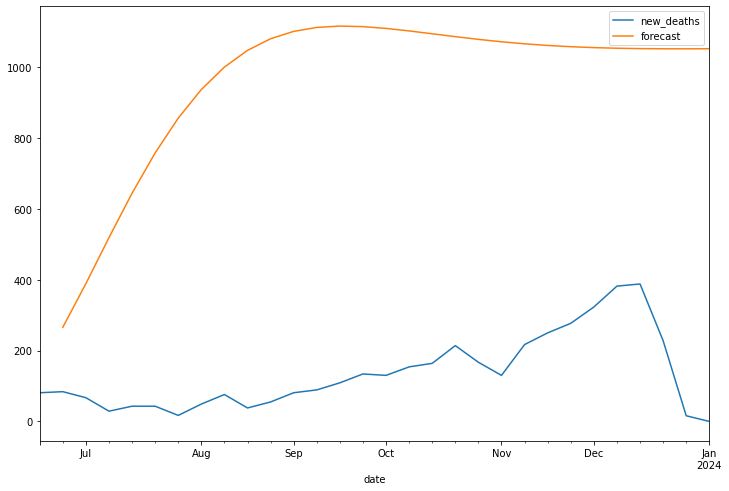

In [117]:
italy_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
italy_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search SARIMA

In [118]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(italy_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66174D+00    |proj g|=  1.05448D-01

At iterate    5    f=  6.59689D+00    |proj g|=  3.39892D-02


 This problem is unconstrained.



At iterate   10    f=  6.59541D+00    |proj g|=  1.12178D-03

At iterate   15    f=  6.59491D+00    |proj g|=  1.27011D-02

At iterate   20    f=  6.57899D+00    |proj g|=  9.44677D-03

At iterate   25    f=  6.57647D+00    |proj g|=  7.65607D-03

At iterate   30    f=  6.57626D+00    |proj g|=  4.50802D-04

At iterate   35    f=  6.57623D+00    |proj g|=  1.76645D-04

At iterate   40    f=  6.57623D+00    |proj g|=  3.71546D-05

At iterate   45    f=  6.57623D+00    |proj g|=  7.25988D-05

At iterate   50    f=  6.57623D+00    |proj g|=  4.87094D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     56   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.59992D+00    |proj g|=  7.03069D-02

At iterate    5    f=  6.59558D+00    |proj g|=  8.97828D-04

At iterate   10    f=  6.59550D+00    |proj g|=  1.68275D-03

At iterate   15    f=  6.58467D+00    |proj g|=  4.06425D-02

At iterate   20    f=  6.57181D+00    |proj g|=  9.58776D-03

At iterate   25    f=  6.56812D+00    |proj g|=  2.89527D-03

At iterate   30    f=  6.56804D+00    |proj g|=  2.36325D-03

At iterate   35    f=  6.56796D+00    |proj g|=  4.07863D-04

At iterate   40    f=  6.56795D+00    |proj g|=  6.64050D-04

At iterate   45    f=  6.56795D+00    |proj g|=  1.30952D-04

At iterate   50    f=  6.56795D+00    |proj g|=  3.81220D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.63181D+00    |proj g|=  5.22800D-02

At iterate   10    f=  6.59700D+00    |proj g|=  4.00506D-02

At iterate   15    f=  6.59477D+00    |proj g|=  6.84155D-04

At iterate   20    f=  6.59254D+00    |proj g|=  1.71417D-02

At iterate   25    f=  6.57624D+00    |proj g|=  2.81101D-02

At iterate   30    f=  6.57516D+00    |proj g|=  7.82230D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     36      1     0     0   9.915D-06   6.575D+00
  F =   6.5751624007263496     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.59511D+00    |proj g|=  1.18561D-03

At iterate   10    f=  6.59508D+00    |proj g|=  1.95114D-03

At iterate   15    f=  6.59359D+00    |proj g|=  4.82859D-02

At iterate   20    f=  6.57413D+00    |proj g|=  1.37459D-02

At iterate   25    f=  6.57391D+00    |proj g|=  5.48022D-03

At iterate   30    f=  6.57347D+00    |proj g|=  5.03240D-03

At iterate   35    f=  6.57344D+00    |proj g|=  6.15663D-04

At iterate   40    f=  6.57332D+00    |proj g|=  5.62115D-03

At iterate   45    f=  6.57171D+00    |proj g|=  3.68151D-02

At iterate   50    f=  6.56550D+00    |proj g|=  1.39569D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.57345D+00    |proj g|=  6.77071D-02

At iterate   10    f=  6.56599D+00    |proj g|=  3.99016D-03

At iterate   15    f=  6.56566D+00    |proj g|=  1.92469D-04

At iterate   20    f=  6.56565D+00    |proj g|=  2.05206D-03

At iterate   25    f=  6.56504D+00    |proj g|=  1.82855D-02

At iterate   30    f=  6.56431D+00    |proj g|=  6.06193D-04

At iterate   35    f=  6.56429D+00    |proj g|=  1.82121D-03

At iterate   40    f=  6.56426D+00    |proj g|=  7.67304D-04

At iterate   45    f=  6.56425D+00    |proj g|=  3.56965D-04

At iterate   50    f=  6.56425D+00    |proj g|=  1.24368D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.56623D+00    |proj g|=  6.50615D-03

At iterate   10    f=  6.56602D+00    |proj g|=  9.70347D-04

At iterate   15    f=  6.56602D+00    |proj g|=  8.52449D-04

At iterate   20    f=  6.56591D+00    |proj g|=  1.28224D-02

At iterate   25    f=  6.55861D+00    |proj g|=  9.50897D-03

At iterate   30    f=  6.55675D+00    |proj g|=  7.68501D-03

At iterate   35    f=  6.55553D+00    |proj g|=  3.80728D-03

At iterate   40    f=  6.55537D+00    |proj g|=  2.52367D-04

At iterate   45    f=  6.55515D+00    |proj g|=  2.86848D-03

At iterate   50    f=  6.55416D+00    |proj g|=  2.73044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.62553D+00    |proj g|=  7.41150D-02

At iterate   10    f=  6.57509D+00    |proj g|=  5.19341D-02

At iterate   15    f=  6.56437D+00    |proj g|=  2.18605D-03

At iterate   20    f=  6.56436D+00    |proj g|=  3.37060D-04

At iterate   25    f=  6.56420D+00    |proj g|=  1.01979D-02

At iterate   30    f=  6.56294D+00    |proj g|=  1.98189D-03

At iterate   35    f=  6.56290D+00    |proj g|=  1.27191D-03

At iterate   40    f=  6.56286D+00    |proj g|=  2.72534D-04

At iterate   45    f=  6.56285D+00    |proj g|=  2.58854D-04

At iterate   50    f=  6.56285D+00    |proj g|=  1.93053D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.56942D+00    |proj g|=  6.65853D-02

At iterate   10    f=  6.56548D+00    |proj g|=  2.19043D-03

At iterate   15    f=  6.56535D+00    |proj g|=  5.76530D-04

At iterate   20    f=  6.56533D+00    |proj g|=  1.47261D-03

At iterate   25    f=  6.56400D+00    |proj g|=  3.33986D-02

At iterate   30    f=  6.56040D+00    |proj g|=  6.65234D-03

At iterate   35    f=  6.56001D+00    |proj g|=  7.70074D-03

At iterate   40    f=  6.55604D+00    |proj g|=  2.25265D-02

At iterate   45    f=  6.55480D+00    |proj g|=  4.79476D-03

At iterate   50    f=  6.55460D+00    |proj g|=  4.44681D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.05152D+00    |proj g|=  1.17266D+00

At iterate    5    f=  6.62302D+00    |proj g|=  1.04622D-01

At iterate   10    f=  6.59228D+00    |proj g|=  5.57784D-03

At iterate   15    f=  6.58087D+00    |proj g|=  7.18230D-03

At iterate   20    f=  6.57389D+00    |proj g|=  7.91958D-03

At iterate   25    f=  6.57029D+00    |proj g|=  1.38497D-02

At iterate   30    f=  6.56872D+00    |proj g|=  1.11805D-02

At iterate   35    f=  6.55875D+00    |proj g|=  2.75607D-02

At iterate   40    f=  6.54915D+00    |proj g|=  6.80536D-04

At iterate   45    f=  6.54904D+00    |proj g|=  6.27014D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.59371D+00    |proj g|=  4.03463D-02

At iterate   10    f=  6.59211D+00    |proj g|=  5.31604D-03

At iterate   15    f=  6.58230D+00    |proj g|=  3.57562D-03

At iterate   20    f=  6.57352D+00    |proj g|=  1.94043D-02

At iterate   25    f=  6.57086D+00    |proj g|=  7.75293D-03

At iterate   30    f=  6.56822D+00    |proj g|=  2.66127D-03

At iterate   35    f=  6.54911D+00    |proj g|=  3.16152D-03

At iterate   40    f=  6.54894D+00    |proj g|=  1.32086D-04

At iterate   45    f=  6.54892D+00    |proj g|=  6.01641D-04

At iterate   50    f=  6.54889D+00    |proj g|=  6.57900D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.63416D+00    |proj g|=  3.43592D-02

At iterate   10    f=  6.61857D+00    |proj g|=  6.99911D-02

At iterate   15    f=  6.59246D+00    |proj g|=  6.41503D-03

At iterate   20    f=  6.59187D+00    |proj g|=  2.05365D-03

At iterate   25    f=  6.57753D+00    |proj g|=  6.41407D-03

At iterate   30    f=  6.57276D+00    |proj g|=  1.25193D-02

At iterate   35    f=  6.56983D+00    |proj g|=  1.29474D-02

At iterate   40    f=  6.56777D+00    |proj g|=  2.04606D-03

At iterate   45    f=  6.55266D+00    |proj g|=  5.57019D-02

At iterate   50    f=  6.54781D+00    |proj g|=  1.47871D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.59282D+00    |proj g|=  2.18024D-02

At iterate   10    f=  6.59154D+00    |proj g|=  4.96558D-03

At iterate   15    f=  6.58234D+00    |proj g|=  1.07043D-02

At iterate   20    f=  6.57781D+00    |proj g|=  2.92352D-02

At iterate   25    f=  6.57285D+00    |proj g|=  1.91450D-03

At iterate   30    f=  6.57150D+00    |proj g|=  2.56976D-03

At iterate   35    f=  6.56880D+00    |proj g|=  5.62257D-03

At iterate   40    f=  6.56365D+00    |proj g|=  2.84462D-02

At iterate   45    f=  6.54980D+00    |proj g|=  1.51987D-02

At iterate   50    f=  6.54805D+00    |proj g|=  8.87826D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77693D+00    |proj g|=  4.76249D-01

At iterate    5    f=  6.56088D+00    |proj g|=  2.71200D-02

At iterate   10    f=  6.55530D+00    |proj g|=  6.07566D-03

At iterate   15    f=  6.55449D+00    |proj g|=  1.16886D-02

At iterate   20    f=  6.55323D+00    |proj g|=  8.81031D-03

At iterate   25    f=  6.55171D+00    |proj g|=  1.76316D-03

At iterate   30    f=  6.55163D+00    |proj g|=  8.78826D-04

At iterate   35    f=  6.54862D+00    |proj g|=  1.00772D-03

At iterate   40    f=  6.54856D+00    |proj g|=  4.95384D-05

At iterate   45    f=  6.54856D+00    |proj g|=  1.40153D-03

At iterate   50    f=  6.54854D+00    |proj g|=  1.71045D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.55638D+00    |proj g|=  1.61600D-02

At iterate   10    f=  6.55531D+00    |proj g|=  3.56265D-03

At iterate   15    f=  6.55523D+00    |proj g|=  5.43749D-04

At iterate   20    f=  6.55515D+00    |proj g|=  6.84693D-04

At iterate   25    f=  6.55515D+00    |proj g|=  1.98618D-04

At iterate   30    f=  6.55488D+00    |proj g|=  3.23121D-03

At iterate   35    f=  6.55427D+00    |proj g|=  3.00555D-02

At iterate   40    f=  6.54889D+00    |proj g|=  1.65120D-02

At iterate   45    f=  6.54571D+00    |proj g|=  4.52570D-03

At iterate   50    f=  6.54384D+00    |proj g|=  2.54117D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.61976D+00    |proj g|=  3.74424D-02

At iterate   10    f=  6.56050D+00    |proj g|=  2.92706D-02

At iterate   15    f=  6.55266D+00    |proj g|=  5.41425D-03

At iterate   20    f=  6.55227D+00    |proj g|=  1.67044D-03

At iterate   25    f=  6.55198D+00    |proj g|=  1.00724D-03

At iterate   30    f=  6.55198D+00    |proj g|=  2.38526D-04

At iterate   35    f=  6.55190D+00    |proj g|=  3.21045D-03

At iterate   40    f=  6.55157D+00    |proj g|=  2.34201D-03

At iterate   45    f=  6.55155D+00    |proj g|=  1.74425D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     52   

 This problem is unconstrained.



At iterate    5    f=  6.55571D+00    |proj g|=  1.64539D-02

At iterate   10    f=  6.55449D+00    |proj g|=  2.84513D-03

At iterate   15    f=  6.55433D+00    |proj g|=  2.41614D-03

At iterate   20    f=  6.55392D+00    |proj g|=  2.14781D-03

At iterate   25    f=  6.55375D+00    |proj g|=  5.42528D-03

At iterate   30    f=  6.54898D+00    |proj g|=  4.31696D-02

At iterate   35    f=  6.54239D+00    |proj g|=  2.37817D-03

At iterate   40    f=  6.54086D+00    |proj g|=  1.18700D-02

At iterate   45    f=  6.53894D+00    |proj g|=  1.43284D-03

At iterate   50    f=  6.53869D+00    |proj g|=  4.76386D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [119]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
8,2,1,1,1,2264.870157
10,2,1,2,1,2266.448095
12,2,2,1,1,2266.697843
9,2,1,1,2,2266.819498
13,2,2,1,2,2267.082620
15,2,2,2,2,2267.307697
11,2,1,2,2,2268.529382
5,1,2,1,2,2268.631580
14,2,2,2,1,2269.732290
4,1,2,1,1,2270.101323


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.05152D+00    |proj g|=  1.17266D+00

At iterate    5    f=  6.62302D+00    |proj g|=  1.04622D-01

At iterate   10    f=  6.59228D+00    |proj g|=  5.57784D-03

At iterate   15    f=  6.58087D+00    |proj g|=  7.18230D-03

At iterate   20    f=  6.57389D+00    |proj g|=  7.91958D-03

At iterate   25    f=  6.57029D+00    |proj g|=  1.38497D-02

At iterate   30    f=  6.56872D+00    |proj g|=  1.11805D-02

At iterate   35    f=  6.55875D+00    |proj g|=  2.75607D-02

At iterate   40    f=  6.54915D+00    |proj g|=  6.80536D-04

At iterate   45    f=  6.54904D+00    |proj g|=  6.27014D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<AxesSubplot:xlabel='date'>

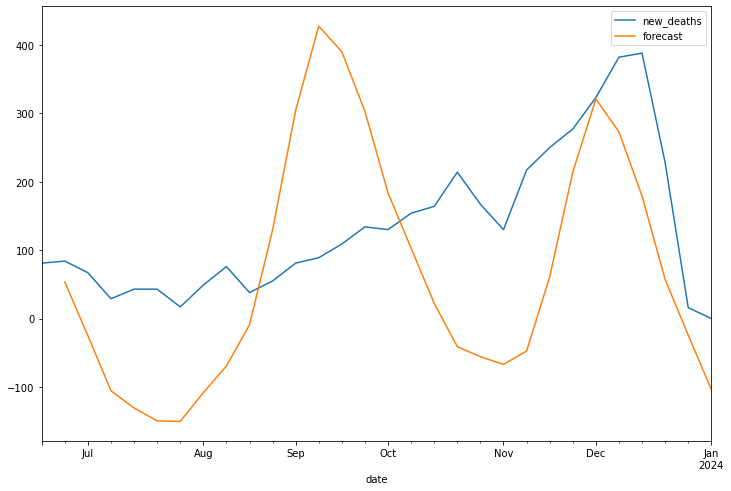

In [120]:
model=sm.tsa.statespace.SARIMAX(italy_train['new_deaths'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
italy_test['forecast']=results.predict(start=173,end=202,dynamic=True)
italy_test[['new_deaths','forecast']].plot(figsize=(12,8))

## autoARIMA

In [121]:
auto_model = auto_arima(italy_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=12
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  172
Model:             SARIMAX(2, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -1196.037
Date:                                 Fri, 16 Feb 2024   AIC                           2408.073
Time:                                         17:29:05   BIC                           2433.206
Sample:                                     03-01-2020   HQIC                          2418.271
                                          - 06-11-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.6553      6.294     -0.104      0.917     -12.991      11

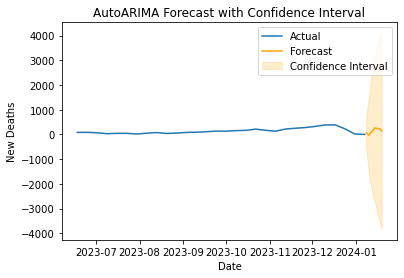

In [122]:
forecast_index = pd.date_range(italy_test.index[-1], periods=n_periods + 1, freq=italy_test.index.freq)[-n_periods:]

plt.plot(italy_test.index, italy_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

# United States

## train/test split

In [2]:
us = pd.read_csv('us_diff.csv')
us = us.set_index('date')
us.index = pd.to_datetime(us.index)
us = us.drop('Unnamed: 0', axis=1)
us.sort_index()
train_size = int(len(us) * 0.8)
us_train, us_test = us[0:train_size], us[train_size:]
us_train=us.iloc[:-30 ]
us_test=us.iloc[-30: ]
print(us_train.shape, us_test.shape)

(172, 1) (30, 1)


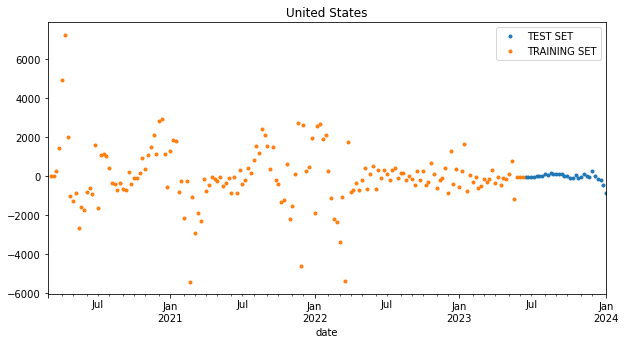

In [3]:
_ = us_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(us_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='United States', style='.')

## basic ARIMA (1,1,1)

In [12]:
model=ARIMA(us_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1482.343
Date:                Sat, 17 Feb 2024   AIC                           2970.686
Time:                        11:12:00   BIC                           2980.111
Sample:                    03-01-2020   HQIC                          2974.510
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3048      0.077     -3.938      0.000      -0.457      -0.153
ma.L1         -0.3168      0.082     -3.884      0.000      -0.477      -0.157
sigma2      1.915e+06    1.2e+05     16.003      0.000    1.68e+06    2.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               110.22
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

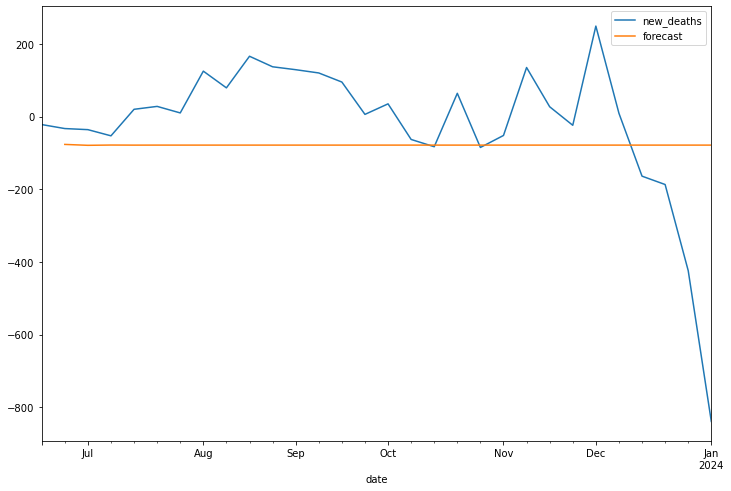

In [13]:
us_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
us_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search ARIMA

In [14]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(us_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
13,4,2,2952.569355
4,2,1,2953.039365
6,2,3,2953.221982
2,1,3,2953.971007
11,3,4,2954.072380
5,2,2,2955.035047
7,2,4,2955.553596
3,1,4,2955.740092
8,3,1,2955.896782
12,4,1,2956.219906


In [15]:
model=ARIMA(us_train['new_deaths'],order=(4,1,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1469.285
Date:                Sat, 17 Feb 2024   AIC                           2952.569
Time:                        11:13:19   BIC                           2974.561
Sample:                    03-01-2020   HQIC                          2961.493
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0514      0.141      7.444      0.000       0.775       1.328
ar.L2          0.1602      0.080      1.993      0.046       0.003       0.318
ar.L3         -0.2314      0.134     -1.731      0.083      -0.493       0.031
ar.L4         -0.1264      0.086     -1.468      0.142      -0.295       0.042
ma.L1         -1.8290      0.121    -15.103      0.000      -2.066      -1.592
ma.L2          0.8292      0.123      6.721      0.000       0.587       1.071
sigma2      1.564e+06   1.44e-07   1.09e+13      0.000    1.56e+06    1.56e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               120.49
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.88e+28. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

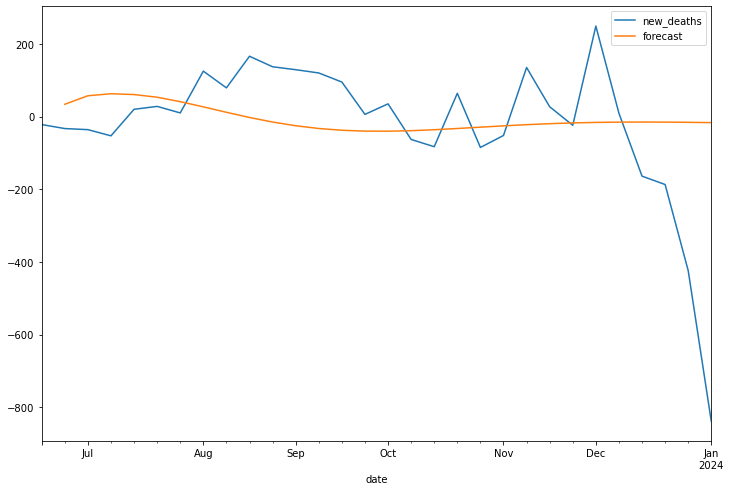

In [16]:
us_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
us_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search SARIMA

In [17]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(us_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.12334D+00    |proj g|=  5.10056D-02


 This problem is unconstrained.



At iterate    5    f=  8.11232D+00    |proj g|=  1.95773D-03

At iterate   10    f=  8.11229D+00    |proj g|=  8.28408D-04

At iterate   15    f=  8.11107D+00    |proj g|=  1.12232D-02

At iterate   20    f=  8.06007D+00    |proj g|=  9.88036D-02

At iterate   25    f=  8.01778D+00    |proj g|=  1.93464D-02

At iterate   30    f=  8.01743D+00    |proj g|=  2.58031D-03

At iterate   35    f=  8.01712D+00    |proj g|=  2.78821D-03

At iterate   40    f=  8.01705D+00    |proj g|=  2.46346D-04

At iterate   45    f=  8.01704D+00    |proj g|=  7.01837D-05

At iterate   50    f=  8.01704D+00    |proj g|=  1.57586D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18031D+00    |proj g|=  1.91148D-01

At iterate    5    f=  8.11530D+00    |proj g|=  2.64411D-03

At iterate   10    f=  8.11459D+00    |proj g|=  1.36938D-02

At iterate   15    f=  8.11152D+00    |proj g|=  1.14719D-03

At iterate   20    f=  8.11148D+00    |proj g|=  2.33415D-04

At iterate   25    f=  8.11143D+00    |proj g|=  3.67362D-03

At iterate   30    f=  8.10349D+00    |proj g|=  4.94361D-02

At iterate   35    f=  8.02302D+00    |proj g|=  7.58038D-03

At iterate   40    f=  8.02211D+00    |proj g|=  7.46352D-05

At iterate   45    f=  8.02190D+00    |proj g|=  6.97039D-04

At iterate   50    f=  8.02131D+00    |proj g|=  3.13816D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.11333D+00    |proj g|=  3.37316D-02

At iterate   10    f=  8.11122D+00    |proj g|=  3.14857D-04

At iterate   15    f=  8.11116D+00    |proj g|=  2.97969D-03

At iterate   20    f=  8.10427D+00    |proj g|=  4.51056D-02

At iterate   25    f=  8.01727D+00    |proj g|=  2.23348D-02

At iterate   30    f=  8.01601D+00    |proj g|=  7.61780D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     38      1     0     0   7.569D-05   8.016D+00
  F =   8.0160078392030005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  8.11118D+00    |proj g|=  1.10853D-02

At iterate   10    f=  8.11088D+00    |proj g|=  1.50231D-03

At iterate   15    f=  8.11060D+00    |proj g|=  2.18440D-03

At iterate   20    f=  8.11055D+00    |proj g|=  2.34052D-04

At iterate   25    f=  8.11052D+00    |proj g|=  1.44834D-03

At iterate   30    f=  8.10783D+00    |proj g|=  6.89471D-02

At iterate   35    f=  8.03501D+00    |proj g|=  7.79159D-02

At iterate   40    f=  8.01709D+00    |proj g|=  1.52372D-03

At iterate   45    f=  8.01708D+00    |proj g|=  4.38721D-04

At iterate   50    f=  8.01706D+00    |proj g|=  2.41292D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.06715D+00    |proj g|=  2.99762D-03

At iterate   10    f=  8.06697D+00    |proj g|=  1.98308D-04

At iterate   15    f=  8.06694D+00    |proj g|=  1.82473D-03

At iterate   20    f=  8.06344D+00    |proj g|=  9.54303D-03

At iterate   25    f=  8.02969D+00    |proj g|=  2.29491D-02

At iterate   30    f=  8.01886D+00    |proj g|=  2.27067D-02

At iterate   35    f=  8.01754D+00    |proj g|=  3.56335D-03

At iterate   40    f=  8.01710D+00    |proj g|=  2.39035D-03

At iterate   45    f=  8.01704D+00    |proj g|=  4.48092D-04

At iterate   50    f=  8.01703D+00    |proj g|=  8.72249D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.07073D+00    |proj g|=  5.13426D-03

At iterate   10    f=  8.07012D+00    |proj g|=  3.45268D-03

At iterate   15    f=  8.06750D+00    |proj g|=  1.84503D-02

At iterate   20    f=  8.06599D+00    |proj g|=  2.42446D-03

At iterate   25    f=  8.06596D+00    |proj g|=  2.77644D-04

At iterate   30    f=  8.06571D+00    |proj g|=  9.83187D-03

At iterate   35    f=  8.02819D+00    |proj g|=  4.37162D-02

At iterate   40    f=  8.02384D+00    |proj g|=  6.93828D-03

At iterate   45    f=  8.02216D+00    |proj g|=  7.08990D-04

At iterate   50    f=  8.02198D+00    |proj g|=  1.64756D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.06871D+00    |proj g|=  2.75965D-02

At iterate   10    f=  8.06567D+00    |proj g|=  1.99453D-04

At iterate   15    f=  8.06565D+00    |proj g|=  2.32785D-03

At iterate   20    f=  8.06295D+00    |proj g|=  2.55426D-02

At iterate   25    f=  8.03305D+00    |proj g|=  3.32088D-02

At iterate   30    f=  8.01619D+00    |proj g|=  1.17944D-02

At iterate   35    f=  8.01597D+00    |proj g|=  1.35326D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     41      1     0     0   2.397D-06   8.016D+00
  F =   8.0159717156777610     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  8.06609D+00    |proj g|=  1.47269D-02

At iterate   10    f=  8.06523D+00    |proj g|=  3.63449D-03

At iterate   15    f=  8.06515D+00    |proj g|=  1.88331D-03

At iterate   20    f=  8.06490D+00    |proj g|=  1.36262D-03

At iterate   25    f=  8.06489D+00    |proj g|=  2.00275D-04

At iterate   30    f=  8.06487D+00    |proj g|=  2.75884D-03

At iterate   35    f=  8.06459D+00    |proj g|=  6.64495D-03

At iterate   40    f=  8.05163D+00    |proj g|=  4.60700D-02

At iterate   45    f=  8.01757D+00    |proj g|=  9.09821D-03

At iterate   50    f=  8.01469D+00    |proj g|=  6.59154D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.10813D+00    |proj g|=  3.34198D-03

At iterate   10    f=  8.10801D+00    |proj g|=  1.02602D-03

At iterate   15    f=  8.10795D+00    |proj g|=  3.69850D-04

At iterate   20    f=  8.10779D+00    |proj g|=  6.36422D-03

At iterate   25    f=  8.08916D+00    |proj g|=  7.10249D-02

At iterate   30    f=  8.02484D+00    |proj g|=  1.11973D-01

At iterate   35    f=  8.01661D+00    |proj g|=  7.54461D-03

At iterate   40    f=  8.01646D+00    |proj g|=  7.42236D-04

At iterate   45    f=  8.01624D+00    |proj g|=  7.26958D-03

At iterate   50    f=  8.01611D+00    |proj g|=  2.81554D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17799D+00    |proj g|=  2.01315D-01

At iterate    5    f=  8.11075D+00    |proj g|=  4.74065D-03

At iterate   10    f=  8.11045D+00    |proj g|=  7.76864D-03

At iterate   15    f=  8.10724D+00    |proj g|=  6.66611D-03

At iterate   20    f=  8.10714D+00    |proj g|=  1.06330D-03

At iterate   25    f=  8.10706D+00    |proj g|=  2.31965D-04

At iterate   30    f=  8.10508D+00    |proj g|=  1.40248D-02

At iterate   35    f=  8.02993D+00    |proj g|=  5.09306D-02

At iterate   40    f=  8.02433D+00    |proj g|=  2.73017D-04

At iterate   45    f=  8.02413D+00    |proj g|=  6.05951D-03

At iterate   50    f=  8.02272D+00    |proj g|=  1.74508D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.10941D+00    |proj g|=  3.67161D-02

At iterate   10    f=  8.10696D+00    |proj g|=  3.75798D-04

At iterate   15    f=  8.10688D+00    |proj g|=  1.34372D-03

At iterate   20    f=  8.10686D+00    |proj g|=  2.12061D-03

At iterate   25    f=  8.10483D+00    |proj g|=  2.77043D-02

At iterate   30    f=  8.03595D+00    |proj g|=  8.92993D-02

At iterate   35    f=  8.01440D+00    |proj g|=  3.47965D-02

At iterate   40    f=  7.98387D+00    |proj g|=  3.48854D-02

At iterate   45    f=  7.97418D+00    |proj g|=  9.35791D-03

At iterate   50    f=  7.97338D+00    |proj g|=  1.09288D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.10713D+00    |proj g|=  1.39233D-02

At iterate   10    f=  8.10670D+00    |proj g|=  1.17012D-03

At iterate   15    f=  8.10643D+00    |proj g|=  3.29307D-03

At iterate   20    f=  8.10639D+00    |proj g|=  6.08903D-04

At iterate   25    f=  8.10631D+00    |proj g|=  1.21059D-03

At iterate   30    f=  8.10629D+00    |proj g|=  2.32354D-04

At iterate   35    f=  8.10615D+00    |proj g|=  6.88130D-03

At iterate   40    f=  8.09702D+00    |proj g|=  4.83926D-02

At iterate   45    f=  8.01871D+00    |proj g|=  4.05678D-02

At iterate   50    f=  8.01566D+00    |proj g|=  2.14395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.06292D+00    |proj g|=  5.97538D-03

At iterate   10    f=  8.06270D+00    |proj g|=  3.78012D-04

At iterate   15    f=  8.06260D+00    |proj g|=  4.10961D-03

At iterate   20    f=  8.06240D+00    |proj g|=  5.48313D-04

At iterate   25    f=  8.06238D+00    |proj g|=  1.94357D-04

At iterate   30    f=  8.06231D+00    |proj g|=  2.49409D-03

At iterate   35    f=  8.03190D+00    |proj g|=  5.45404D-02

At iterate   40    f=  8.01706D+00    |proj g|=  1.62065D-03

At iterate   45    f=  8.01705D+00    |proj g|=  1.70228D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     55   

 This problem is unconstrained.



At iterate    5    f=  8.06603D+00    |proj g|=  4.59616D-03

At iterate   10    f=  8.06588D+00    |proj g|=  3.00243D-03

At iterate   15    f=  8.06323D+00    |proj g|=  2.44508D-02

At iterate   20    f=  8.06140D+00    |proj g|=  4.51028D-03

At iterate   25    f=  8.06137D+00    |proj g|=  5.45398D-04

At iterate   30    f=  8.06136D+00    |proj g|=  1.68519D-03

At iterate   35    f=  8.06113D+00    |proj g|=  3.69376D-03

At iterate   40    f=  8.06109D+00    |proj g|=  1.02786D-03

At iterate   45    f=  8.06101D+00    |proj g|=  3.84511D-03

At iterate   50    f=  8.05142D+00    |proj g|=  1.09066D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.06518D+00    |proj g|=  5.11865D-02

At iterate   10    f=  8.06136D+00    |proj g|=  1.73389D-03

At iterate   15    f=  8.06134D+00    |proj g|=  1.19798D-03

At iterate   20    f=  8.06109D+00    |proj g|=  3.20464D-03

At iterate   25    f=  8.06106D+00    |proj g|=  6.46565D-04

At iterate   30    f=  8.06105D+00    |proj g|=  8.02503D-04

At iterate   35    f=  8.05981D+00    |proj g|=  2.06141D-02

At iterate   40    f=  8.02430D+00    |proj g|=  9.41406D-02

At iterate   45    f=  8.01597D+00    |proj g|=  4.05194D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     56   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.09187D+00    |proj g|=  1.22153D-01

At iterate    5    f=  8.06131D+00    |proj g|=  1.19305D-02

At iterate   10    f=  8.06095D+00    |proj g|=  1.58347D-03

At iterate   15    f=  8.06067D+00    |proj g|=  4.05155D-03

At iterate   20    f=  8.06049D+00    |proj g|=  8.14131D-04

At iterate   25    f=  8.06048D+00    |proj g|=  4.12949D-04

At iterate   30    f=  8.06040D+00    |proj g|=  3.00636D-03

At iterate   35    f=  8.06035D+00    |proj g|=  3.05899D-04

At iterate   40    f=  8.06032D+00    |proj g|=  2.92452D-03

At iterate   45    f=  8.05977D+00    |proj g|=  6.51142D-03

At iterate   50    f=  8.04996D+00    |proj g|=  8.32918D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [18]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
10,2,1,2,1,2756.841822
0,1,1,1,1,2767.861751
2,1,1,2,1,2769.506697
8,2,1,1,1,2769.540139
4,1,2,1,1,2769.858101
1,1,1,1,2,2771.331321
6,1,2,2,1,2771.494270
12,2,2,1,1,2771.866567
3,1,1,2,2,2771.868787
7,1,2,2,2,2773.054032


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.12531D+00    |proj g|=  6.85574D-02

At iterate    5    f=  8.10941D+00    |proj g|=  3.67161D-02

At iterate   10    f=  8.10696D+00    |proj g|=  3.75798D-04

At iterate   15    f=  8.10688D+00    |proj g|=  1.34372D-03

At iterate   20    f=  8.10686D+00    |proj g|=  2.12061D-03

At iterate   25    f=  8.10483D+00    |proj g|=  2.77043D-02

At iterate   30    f=  8.03595D+00    |proj g|=  8.92993D-02

At iterate   35    f=  8.01440D+00    |proj g|=  3.47965D-02

At iterate   40    f=  7.98387D+00    |proj g|=  3.48854D-02

At iterate   45    f=  7.97418D+00    |proj g|=  9.35791D-03

At iterate   50    f=  7.97338D+00    |proj g|=  1.09288D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<AxesSubplot:xlabel='date'>

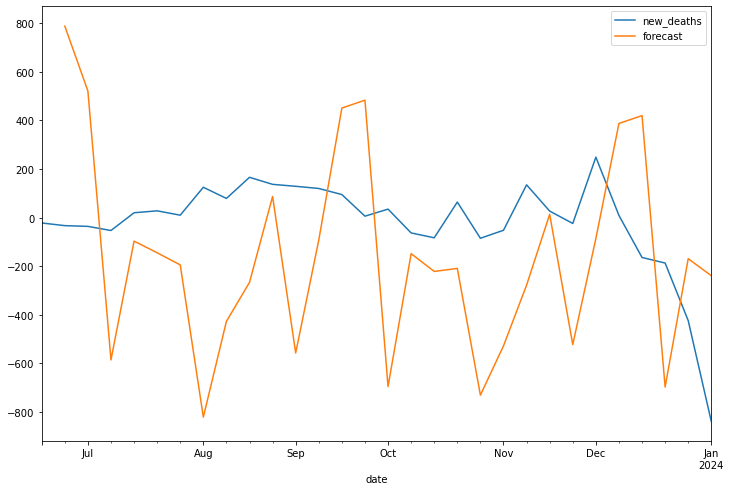

In [19]:
model=sm.tsa.statespace.SARIMAX(us_train['new_deaths'],order=(2, 1, 1),seasonal_order=(2,1,1,12))
results=model.fit()
us_test['forecast']=results.predict(start=173,end=202,dynamic=True)
us_test[['new_deaths','forecast']].plot(figsize=(12,8))

## autoARIMA

In [21]:
# need un-differenced data

# Czechia

## train/test split

In [4]:
czechia = pd.read_csv('czechia_diff.csv')
czechia = czechia.set_index('date')
czechia.index = pd.to_datetime(czechia.index)
czechia = czechia.drop('Unnamed: 0', axis=1)
czechia.sort_index()
train_size = int(len(czechia) * 0.8)
czechia_train, czechia_test = czechia[0:train_size], czechia[train_size:]
czechia_train=czechia.iloc[:-30 ]
czechia_test=czechia.iloc[-30: ]
print(czechia_train.shape, czechia_test.shape)

(172, 1) (30, 1)


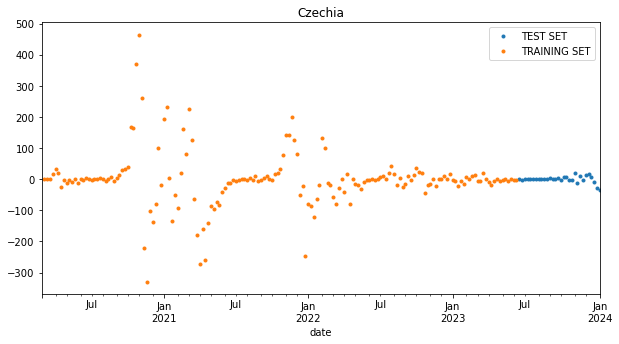

In [5]:
_ = czechia_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(czechia_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Czechia', style='.')

## basic ARIMA (1,1,1)

In [26]:
model=ARIMA(czechia_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -969.556
Date:                Sat, 17 Feb 2024   AIC                           1945.112
Time:                        11:20:02   BIC                           1954.537
Sample:                    03-01-2020   HQIC                          1948.936
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6701      0.048     13.988      0.000       0.576       0.764
ma.L1         -0.9998      4.962     -0.202      0.840     -10.724       8.725
sigma2      4702.8297   2.33e+04      0.202      0.840    -4.1e+04    5.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   4.48   Jarque-Bera (JB):               627.23
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

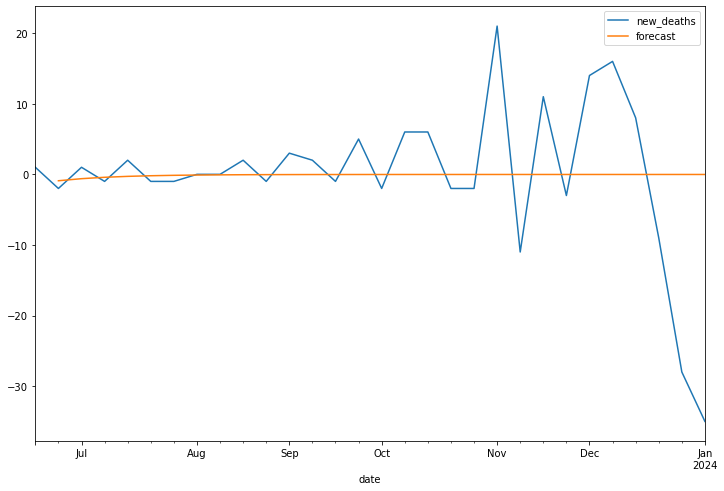

In [27]:
czechia_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
czechia_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search ARIMA

In [28]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(czechia_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
12,4,1,1932.417427
5,2,2,1933.351036
13,4,2,1934.375041
8,3,1,1936.132365
14,4,3,1936.374474
4,2,1,1936.853357
15,4,4,1937.222770
10,3,3,1937.256030
3,1,4,1937.786454
7,2,4,1938.774046


In [29]:
model=ARIMA(czechia_train['new_deaths'],order=(4,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -960.209
Date:                Sat, 17 Feb 2024   AIC                           1932.417
Time:                        11:21:14   BIC                           1951.267
Sample:                    03-01-2020   HQIC                          1940.066
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7717      0.053     14.679      0.000       0.669       0.875
ar.L2         -0.1623      0.057     -2.832      0.005      -0.275      -0.050
ar.L3          0.0181      0.073      0.248      0.804      -0.125       0.162
ar.L4         -0.1801      0.061     -2.934      0.003      -0.300      -0.060
ma.L1         -0.9998      3.680     -0.272      0.786      -8.213       6.213
sigma2      4181.0977   1.53e+04      0.273      0.785   -2.58e+04    3.42e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               350.61
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

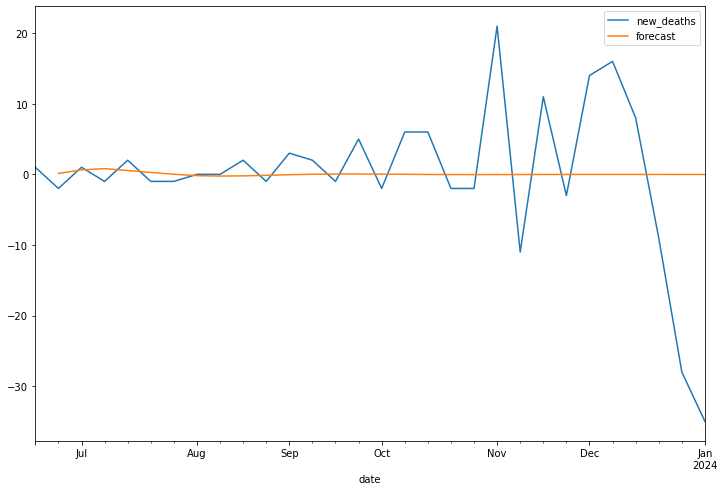

In [30]:
czechia_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
czechia_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search SARIMA

In [31]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(czechia_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52724D+00    |proj g|=  1.09580D-01


 This problem is unconstrained.



At iterate    5    f=  5.49265D+00    |proj g|=  5.54996D-03

At iterate   10    f=  5.48667D+00    |proj g|=  8.74228D-03

At iterate   15    f=  5.40414D+00    |proj g|=  8.62526D-02

At iterate   20    f=  5.39978D+00    |proj g|=  1.00476D-03

At iterate   25    f=  5.39972D+00    |proj g|=  6.65343D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   6.653D-06   5.400D+00
  F =   5.3997224729032922     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.51325D+00    |proj g|=  7.74685D-02

At iterate    5    f=  5.49395D+00    |proj g|=  2.25142D-02

At iterate   10    f=  5.48040D+00    |proj g|=  1.16250D-02

At iterate   15    f=  5.40243D+00    |proj g|=  1.28314D-03

At iterate   20    f=  5.40083D+00    |proj g|=  4.17201D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     30      1     0     0   7.957D-06   5.401D+00
  F =   5.4007406627755801     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  5.49050D+00    |proj g|=  1.95128D-02

At iterate   10    f=  5.48827D+00    |proj g|=  1.00611D-02

At iterate   15    f=  5.48045D+00    |proj g|=  1.91649D-02

At iterate   20    f=  5.39773D+00    |proj g|=  2.20678D-03

At iterate   25    f=  5.39726D+00    |proj g|=  6.31688D-04

At iterate   30    f=  5.39725D+00    |proj g|=  4.67111D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     34      1     0     0   4.671D-06   5.397D+00
  F =   5.3972532052870994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.49163D+00    |proj g|=  1.96170D-02

At iterate   10    f=  5.48758D+00    |proj g|=  1.85354D-02

At iterate   15    f=  5.40736D+00    |proj g|=  8.62524D-02

At iterate   20    f=  5.40279D+00    |proj g|=  2.76135D-03

At iterate   25    f=  5.40236D+00    |proj g|=  6.03782D-03

At iterate   30    f=  5.40159D+00    |proj g|=  1.87584D-02

At iterate   35    f=  5.40100D+00    |proj g|=  1.21567D-02

At iterate   40    f=  5.40005D+00    |proj g|=  1.76761D-02

At iterate   45    f=  5.39968D+00    |proj g|=  7.70670D-04

At iterate   50    f=  5.39939D+00    |proj g|=  5.87988D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.43751D+00    |proj g|=  3.18025D-02

At iterate   10    f=  5.42990D+00    |proj g|=  1.09153D-02

At iterate   15    f=  5.35204D+00    |proj g|=  9.77047D-02

At iterate   20    f=  5.31264D+00    |proj g|=  3.48103D-03

At iterate   25    f=  5.31151D+00    |proj g|=  5.79688D-03

At iterate   30    f=  5.31124D+00    |proj g|=  1.69129D-03

At iterate   35    f=  5.31120D+00    |proj g|=  2.70901D-04

At iterate   40    f=  5.31119D+00    |proj g|=  5.19571D-05

At iterate   45    f=  5.31119D+00    |proj g|=  7.77306D-05

At iterate   50    f=  5.31119D+00    |proj g|=  1.75434D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.43727D+00    |proj g|=  1.16068D-02

At iterate   10    f=  5.41530D+00    |proj g|=  1.90473D-02

At iterate   15    f=  5.33707D+00    |proj g|=  2.68933D-02

At iterate   20    f=  5.31097D+00    |proj g|=  7.22000D-04

At iterate   25    f=  5.31074D+00    |proj g|=  4.14454D-04

At iterate   30    f=  5.31067D+00    |proj g|=  5.50792D-05

At iterate   35    f=  5.31067D+00    |proj g|=  3.21766D-04

At iterate   40    f=  5.31066D+00    |proj g|=  1.66002D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     50      1     0     0   7.560D-06   5.311D+00
  F =   5.31065936330

 This problem is unconstrained.



At iterate    5    f=  5.43561D+00    |proj g|=  1.21776D-02

At iterate   10    f=  5.42922D+00    |proj g|=  6.41023D-03

At iterate   15    f=  5.41741D+00    |proj g|=  3.07483D-02

At iterate   20    f=  5.31699D+00    |proj g|=  9.05677D-02

At iterate   25    f=  5.30776D+00    |proj g|=  1.03688D-03

At iterate   30    f=  5.30767D+00    |proj g|=  5.82453D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     40      1     0     0   2.969D-06   5.308D+00
  F =   5.3076701688103327     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.43520D+00    |proj g|=  7.88874D-03

At iterate   10    f=  5.42815D+00    |proj g|=  1.53345D-02

At iterate   15    f=  5.40744D+00    |proj g|=  2.69003D-02

At iterate   20    f=  5.31454D+00    |proj g|=  9.74938D-03

At iterate   25    f=  5.31177D+00    |proj g|=  5.08361D-03

At iterate   30    f=  5.31004D+00    |proj g|=  3.03426D-02

At iterate   35    f=  5.30874D+00    |proj g|=  4.19141D-02

At iterate   40    f=  5.30741D+00    |proj g|=  6.44109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     58      1     0     0   4.786D-06   5.307D+00
  F =   5.30740495775

 This problem is unconstrained.



At iterate    5    f=  5.45012D+00    |proj g|=  1.19916D-02

At iterate   10    f=  5.43783D+00    |proj g|=  1.15703D-02

At iterate   15    f=  5.34457D+00    |proj g|=  7.32451D-02

At iterate   20    f=  5.30582D+00    |proj g|=  7.66368D-03

At iterate   25    f=  5.30401D+00    |proj g|=  2.99839D-03

At iterate   30    f=  5.30379D+00    |proj g|=  1.92537D-03

At iterate   35    f=  5.30374D+00    |proj g|=  1.39782D-04

At iterate   40    f=  5.30374D+00    |proj g|=  5.11491D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     51      1     0     0   1.038D-04   5.304D+00
  F =   5.30373792690

 This problem is unconstrained.



At iterate    5    f=  5.45116D+00    |proj g|=  4.29860D-02

At iterate   10    f=  5.43800D+00    |proj g|=  1.64798D-02

At iterate   15    f=  5.30348D+00    |proj g|=  4.00813D-03

At iterate   20    f=  5.30345D+00    |proj g|=  4.68444D-04

At iterate   25    f=  5.30313D+00    |proj g|=  1.43263D-02

At iterate   30    f=  5.30283D+00    |proj g|=  5.38373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     49      1     0     0   1.564D-05   5.303D+00
  F =   5.3028271013245014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.45718D+00    |proj g|=  1.11913D-01

At iterate   10    f=  5.43983D+00    |proj g|=  7.08098D-03

At iterate   15    f=  5.35365D+00    |proj g|=  8.95629D-02

At iterate   20    f=  5.30110D+00    |proj g|=  1.17865D-02

At iterate   25    f=  5.29999D+00    |proj g|=  8.27291D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     32      1     0     0   9.069D-06   5.300D+00
  F =   5.2999824920478256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  5.45097D+00    |proj g|=  1.56920D-02

At iterate   10    f=  5.43533D+00    |proj g|=  1.31378D-02

At iterate   15    f=  5.36367D+00    |proj g|=  1.54227D-01

At iterate   20    f=  5.30535D+00    |proj g|=  2.07748D-03

At iterate   25    f=  5.30490D+00    |proj g|=  1.15457D-02

At iterate   30    f=  5.30370D+00    |proj g|=  1.28341D-03

At iterate   35    f=  5.30369D+00    |proj g|=  1.05757D-03

At iterate   40    f=  5.30366D+00    |proj g|=  3.47942D-03

At iterate   45    f=  5.30337D+00    |proj g|=  7.02671D-03

At iterate   50    f=  5.30324D+00    |proj g|=  2.26920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.44681D+00    |proj g|=  3.98733D-02

At iterate   10    f=  5.43256D+00    |proj g|=  1.28048D-02

At iterate   15    f=  5.42401D+00    |proj g|=  2.57080D-02

At iterate   20    f=  5.39544D+00    |proj g|=  1.37647D-02

At iterate   25    f=  5.35027D+00    |proj g|=  7.04759D-02

At iterate   30    f=  5.33270D+00    |proj g|=  8.76313D-03

At iterate   35    f=  5.32724D+00    |proj g|=  1.25087D-02

At iterate   40    f=  5.32199D+00    |proj g|=  1.92477D-02

At iterate   45    f=  5.30115D+00    |proj g|=  3.80465D-02

At iterate   50    f=  5.29082D+00    |proj g|=  8.99749D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.45072D+00    |proj g|=  3.14237D-02

At iterate   10    f=  5.43169D+00    |proj g|=  1.21455D-02

At iterate   15    f=  5.41723D+00    |proj g|=  2.12768D-02

At iterate   20    f=  5.37211D+00    |proj g|=  2.93709D-02

At iterate   25    f=  5.33445D+00    |proj g|=  1.58243D-02

At iterate   30    f=  5.32573D+00    |proj g|=  4.73961D-03

At iterate   35    f=  5.31699D+00    |proj g|=  2.16636D-02

At iterate   40    f=  5.29124D+00    |proj g|=  1.09534D-02

At iterate   45    f=  5.29043D+00    |proj g|=  7.59070D-04

At iterate   50    f=  5.29040D+00    |proj g|=  1.42716D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.45128D+00    |proj g|=  8.56408D-02

At iterate   10    f=  5.42982D+00    |proj g|=  1.50513D-02

At iterate   15    f=  5.42268D+00    |proj g|=  8.13326D-03

At iterate   20    f=  5.38972D+00    |proj g|=  5.06075D-02

At iterate   25    f=  5.36470D+00    |proj g|=  2.61755D-02

At iterate   30    f=  5.33442D+00    |proj g|=  7.49302D-02

At iterate   35    f=  5.32538D+00    |proj g|=  1.56151D-02

At iterate   40    f=  5.32403D+00    |proj g|=  1.09451D-02

At iterate   45    f=  5.31044D+00    |proj g|=  1.31777D-01

At iterate   50    f=  5.28829D+00    |proj g|=  2.23657D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.45356D+00    |proj g|=  2.92154D-02

At iterate   10    f=  5.43203D+00    |proj g|=  1.33312D-02

At iterate   15    f=  5.42574D+00    |proj g|=  1.07851D-02

At iterate   20    f=  5.39791D+00    |proj g|=  4.23319D-02

At iterate   25    f=  5.34098D+00    |proj g|=  4.39624D-03

At iterate   30    f=  5.33710D+00    |proj g|=  1.17227D-02

At iterate   35    f=  5.33523D+00    |proj g|=  3.52181D-03

At iterate   40    f=  5.33111D+00    |proj g|=  2.95286D-02

At iterate   45    f=  5.32165D+00    |proj g|=  5.87479D-02

At iterate   50    f=  5.29321D+00    |proj g|=  3.47152D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [32]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
12,2,2,1,1,1834.043132
14,2,2,2,1,1835.170638
13,2,2,1,2,1835.897608
8,2,1,1,1,1836.485847
10,2,1,2,1,1837.193977
9,2,1,1,2,1838.172523
15,2,2,2,2,1838.864647
4,1,2,1,1,1839.048327
6,1,2,2,1,1839.838538
11,2,1,2,2,1840.316023


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.51200D+00    |proj g|=  1.32182D-01

At iterate    5    f=  5.44681D+00    |proj g|=  3.98733D-02

At iterate   10    f=  5.43256D+00    |proj g|=  1.28048D-02

At iterate   15    f=  5.42401D+00    |proj g|=  2.57080D-02

At iterate   20    f=  5.39544D+00    |proj g|=  1.37647D-02

At iterate   25    f=  5.35027D+00    |proj g|=  7.04759D-02

At iterate   30    f=  5.33270D+00    |proj g|=  8.76313D-03

At iterate   35    f=  5.32724D+00    |proj g|=  1.25087D-02

At iterate   40    f=  5.32199D+00    |proj g|=  1.92477D-02

At iterate   45    f=  5.30115D+00    |proj g|=  3.80465D-02

At iterate   50    f=  5.29082D+00    |proj g|=  8.99749D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<AxesSubplot:xlabel='date'>

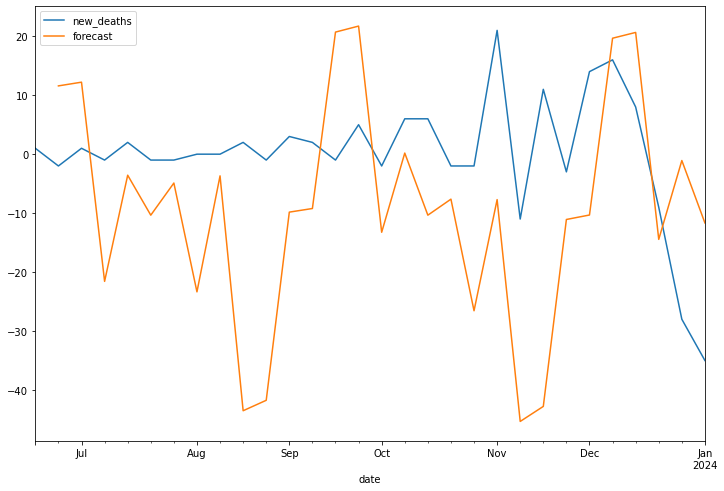

In [33]:
model=sm.tsa.statespace.SARIMAX(czechia_train['new_deaths'],order=(2, 1, 2),seasonal_order=(1,1,1,12))
results=model.fit()
czechia_test['forecast']=results.predict(start=173,end=202,dynamic=True)
czechia_test[['new_deaths','forecast']].plot(figsize=(12,8))

## autoARIMA

In [22]:
# need un-differenced data

# Estonia

## train/test split

In [2]:
estonia = pd.read_csv('estonia_diff.csv')
estonia = estonia.set_index('date')
estonia.index = pd.to_datetime(estonia.index)
estonia = estonia.drop('Unnamed: 0', axis=1)
estonia.sort_index()
train_size = int(len(estonia) * 0.8)
estonia_train, estonia_test = estonia[0:train_size], estonia[train_size:]
estonia_train=estonia.iloc[:-30 ]
estonia_test=estonia.iloc[-30: ]
print(estonia_train.shape, estonia_test.shape)

(172, 1) (30, 1)


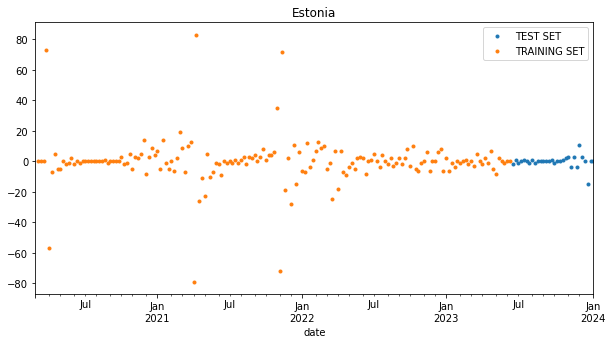

In [3]:
_ = estonia_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(estonia_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Estonia', style='.')

## basic ARIMA (1,1,1)

In [4]:
model=ARIMA(estonia_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -687.171
Date:                Sat, 17 Feb 2024   AIC                           1380.342
Time:                        16:23:36   BIC                           1389.767
Sample:                    03-01-2020   HQIC                          1384.166
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5504      0.028    -19.775      0.000      -0.605      -0.496
ma.L1         -0.9997      3.131     -0.319      0.750      -7.137       5.138
sigma2       166.8596    524.571      0.318      0.750    -861.281    1195.000
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):               855.27
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                            -0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

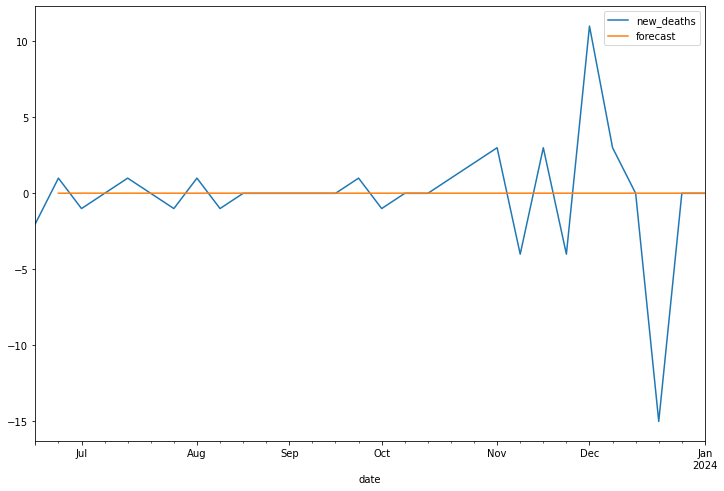

In [5]:
estonia_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
estonia_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search ARIMA

In [6]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(estonia_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
2,1,3,1374.916750
4,2,1,1375.689416
12,4,1,1375.852408
1,1,2,1376.069248
3,1,4,1376.872219
8,3,1,1377.141029
5,2,2,1377.452794
9,3,2,1378.044134
14,4,3,1378.135848
7,2,4,1378.432839


In [7]:
model=ARIMA(estonia_train['new_deaths'],order=(1,1,3))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -682.458
Date:                Sat, 17 Feb 2024   AIC                           1374.917
Time:                        16:25:40   BIC                           1390.625
Sample:                    03-01-2020   HQIC                          1381.291
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2752      0.183      1.502      0.133      -0.084       0.634
ma.L1         -1.9480     13.633     -0.143      0.886     -28.669      24.773
ma.L2          1.3676     12.984      0.105      0.916     -24.080      26.815
ma.L3         -0.4195      5.752     -0.073      0.942     -11.693      10.854
sigma2       157.6889   2138.529      0.074      0.941   -4033.751    4349.129
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               818.36
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                            -0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

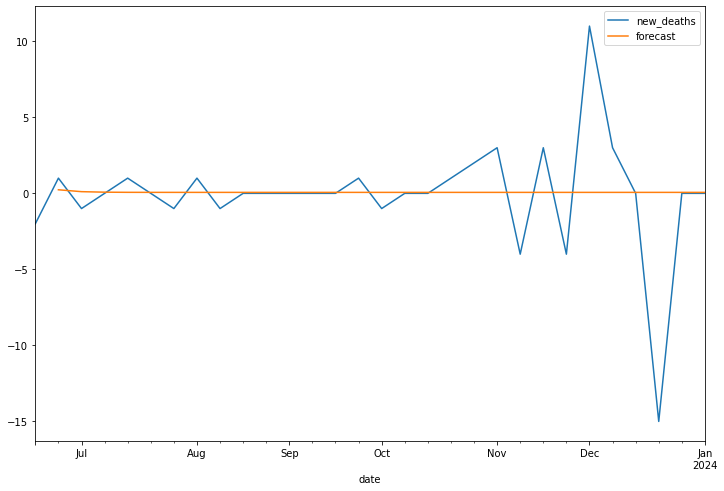

In [8]:
estonia_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
estonia_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search SARIMA

In [9]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(estonia_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91877D+00    |proj g|=  8.59095D-02


 This problem is unconstrained.



At iterate    5    f=  3.86675D+00    |proj g|=  1.58469D-02

At iterate   10    f=  3.83104D+00    |proj g|=  2.35913D-02

At iterate   15    f=  3.82856D+00    |proj g|=  2.17742D-03

At iterate   20    f=  3.82795D+00    |proj g|=  1.28486D-03

At iterate   25    f=  3.82790D+00    |proj g|=  2.28882D-04

At iterate   30    f=  3.82789D+00    |proj g|=  1.22307D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     38      1     0     0   4.690D-05   3.828D+00
  F =   3.8278924435431243     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  3.84795D+00    |proj g|=  4.52130D-02

At iterate   10    f=  3.83126D+00    |proj g|=  1.88341D-03

At iterate   15    f=  3.82812D+00    |proj g|=  3.30274D-03

At iterate   20    f=  3.82534D+00    |proj g|=  1.31738D-02

At iterate   25    f=  3.82510D+00    |proj g|=  1.88557D-04

At iterate   30    f=  3.82505D+00    |proj g|=  2.44479D-04

At iterate   35    f=  3.82504D+00    |proj g|=  2.93656D-04

At iterate   40    f=  3.82503D+00    |proj g|=  1.09738D-04

At iterate   45    f=  3.82503D+00    |proj g|=  4.23782D-05

At iterate   50    f=  3.82503D+00    |proj g|=  2.09578D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.86893D+00    |proj g|=  6.62738D-02

At iterate   10    f=  3.83381D+00    |proj g|=  5.31684D-02

At iterate   15    f=  3.82856D+00    |proj g|=  2.40959D-03

At iterate   20    f=  3.82670D+00    |proj g|=  4.95639D-04

At iterate   25    f=  3.82643D+00    |proj g|=  3.81615D-04

At iterate   30    f=  3.82641D+00    |proj g|=  2.24606D-04

At iterate   35    f=  3.82640D+00    |proj g|=  1.15699D-03

At iterate   40    f=  3.82635D+00    |proj g|=  4.92063D-04

At iterate   45    f=  3.82634D+00    |proj g|=  2.17518D-04

At iterate   50    f=  3.82634D+00    |proj g|=  4.86988D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88896D+00    |proj g|=  7.80650D-02

At iterate    5    f=  3.86597D+00    |proj g|=  1.65565D-02

At iterate   10    f=  3.82426D+00    |proj g|=  1.77842D-02

At iterate   15    f=  3.82093D+00    |proj g|=  1.51311D-03

At iterate   20    f=  3.82055D+00    |proj g|=  4.64919D-04

At iterate   25    f=  3.82045D+00    |proj g|=  4.54211D-04

At iterate   30    f=  3.82044D+00    |proj g|=  2.98093D-04

At iterate   35    f=  3.82044D+00    |proj g|=  7.20974D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  3.85924D+00    |proj g|=  1.62634D-02

At iterate   10    f=  3.81612D+00    |proj g|=  7.75629D-03

At iterate   15    f=  3.81457D+00    |proj g|=  9.14161D-03

At iterate   20    f=  3.81171D+00    |proj g|=  2.09523D-03

At iterate   25    f=  3.81146D+00    |proj g|=  7.43712D-04

At iterate   30    f=  3.81143D+00    |proj g|=  3.64175D-04

At iterate   35    f=  3.81143D+00    |proj g|=  1.08115D-04

At iterate   40    f=  3.81143D+00    |proj g|=  3.92622D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     50      1     0     0   2.383D-05   3.811D+00
  F =   3.81142905182

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86951D+00    |proj g|=  2.55627D-02

At iterate    5    f=  3.85133D+00    |proj g|=  8.25725D-02

At iterate   10    f=  3.81698D+00    |proj g|=  3.71038D-03

At iterate   15    f=  3.81447D+00    |proj g|=  8.36526D-03

At iterate   20    f=  3.81188D+00    |proj g|=  2.95953D-03

At iterate   25    f=  3.81173D+00    |proj g|=  4.37697D-04

At iterate   30    f=  3.81163D+00    |proj g|=  9.82414D-04

At iterate   35    f=  3.81157D+00    |proj g|=  1.36600D-03

At iterate   40    f=  3.81155D+00    |proj g|=  9.57735D-04

At iterate   45    f=  3.81155D+00    |proj g|=  3.80299D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     68      1     0     0   6.109D-04   3.812D+00
  F =   3.8115456679097552     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89512D+00    |proj g|=  2.46307D-02


 This problem is unconstrained.



At iterate    5    f=  3.84780D+00    |proj g|=  1.57047D-02

At iterate   10    f=  3.81679D+00    |proj g|=  3.41961D-02

At iterate   15    f=  3.81541D+00    |proj g|=  2.46622D-03

At iterate   20    f=  3.81296D+00    |proj g|=  2.03496D-02

At iterate   25    f=  3.81154D+00    |proj g|=  2.83829D-03

At iterate   30    f=  3.81143D+00    |proj g|=  1.16066D-03

At iterate   35    f=  3.81141D+00    |proj g|=  2.83548D-04

At iterate   40    f=  3.81141D+00    |proj g|=  1.38080D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   45    f=  3.81141D+00    |proj g|=  1.44948D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     66      1     0     0   1.449D-05   3.811D+00
  F =   3.8114093802166114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87520D+00    |proj g|=  3.85186D-02


 This problem is unconstrained.



At iterate    5    f=  3.85729D+00    |proj g|=  4.45080D-02

At iterate   10    f=  3.81334D+00    |proj g|=  1.29654D-02

At iterate   15    f=  3.81134D+00    |proj g|=  1.15027D-02

At iterate   20    f=  3.80843D+00    |proj g|=  1.20261D-02

At iterate   25    f=  3.80731D+00    |proj g|=  2.77297D-03

At iterate   30    f=  3.80717D+00    |proj g|=  3.04048D-03

At iterate   35    f=  3.80714D+00    |proj g|=  1.03865D-03

At iterate   40    f=  3.80712D+00    |proj g|=  1.16880D-04

At iterate   45    f=  3.80712D+00    |proj g|=  8.24806D-05

At iterate   50    f=  3.80712D+00    |proj g|=  5.44953D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.85469D+00    |proj g|=  1.88650D-02

At iterate   10    f=  3.81611D+00    |proj g|=  4.73889D-02

At iterate   15    f=  3.81328D+00    |proj g|=  1.15050D-02

At iterate   20    f=  3.81060D+00    |proj g|=  1.76735D-03

At iterate   25    f=  3.81028D+00    |proj g|=  4.03779D-04

At iterate   30    f=  3.81022D+00    |proj g|=  3.85826D-04

At iterate   35    f=  3.81022D+00    |proj g|=  4.26672D-04

At iterate   40    f=  3.81022D+00    |proj g|=  5.90402D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     51      1     0     0   7.528D-05   3.810D+00
  F =   3.81021979462

 This problem is unconstrained.



At iterate    5    f=  3.84378D+00    |proj g|=  3.23234D-02

At iterate   10    f=  3.81551D+00    |proj g|=  2.89409D-03

At iterate   15    f=  3.81176D+00    |proj g|=  2.94225D-03

At iterate   20    f=  3.81114D+00    |proj g|=  2.53639D-03

At iterate   25    f=  3.81085D+00    |proj g|=  8.83655D-04

At iterate   30    f=  3.81078D+00    |proj g|=  2.69364D-04

At iterate   35    f=  3.81076D+00    |proj g|=  3.86612D-04

At iterate   40    f=  3.81076D+00    |proj g|=  4.67652D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  3.81075D+00    |proj g|=  6.71529D-05

At iterate   50    f=  3.81075D+00    |proj g|=  1.36501D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     81      2     0     0   1.365D-04   3.811D+00
  F =   3.8107527825420973     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90811D+00    |proj g|=  1.01504D-01


 This problem is unconstrained.



At iterate    5    f=  3.86524D+00    |proj g|=  5.54928D-02

At iterate   10    f=  3.82076D+00    |proj g|=  4.58576D-02

At iterate   15    f=  3.81338D+00    |proj g|=  2.57875D-03

At iterate   20    f=  3.81191D+00    |proj g|=  1.20291D-02

At iterate   25    f=  3.81040D+00    |proj g|=  3.70840D-03

At iterate   30    f=  3.81023D+00    |proj g|=  3.50569D-04

At iterate   35    f=  3.81021D+00    |proj g|=  5.68153D-04

At iterate   40    f=  3.81021D+00    |proj g|=  5.76855D-04

At iterate   45    f=  3.81021D+00    |proj g|=  4.81047D-05

At iterate   50    f=  3.81021D+00    |proj g|=  4.57101D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.85515D+00    |proj g|=  1.83057D-02

At iterate   10    f=  3.81124D+00    |proj g|=  1.08408D-02

At iterate   15    f=  3.81026D+00    |proj g|=  2.88696D-03

At iterate   20    f=  3.80770D+00    |proj g|=  1.77611D-02

At iterate   25    f=  3.80651D+00    |proj g|=  3.62735D-03

At iterate   30    f=  3.80636D+00    |proj g|=  4.74520D-04

At iterate   35    f=  3.80631D+00    |proj g|=  1.40174D-04

At iterate   40    f=  3.80631D+00    |proj g|=  3.06993D-04

At iterate   45    f=  3.80631D+00    |proj g|=  2.89252D-04

At iterate   50    f=  3.80630D+00    |proj g|=  6.35751D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.85514D+00    |proj g|=  1.58290D-02

At iterate   10    f=  3.81420D+00    |proj g|=  1.07422D-02

At iterate   15    f=  3.81184D+00    |proj g|=  1.96617D-03

At iterate   20    f=  3.81134D+00    |proj g|=  1.19417D-02

At iterate   25    f=  3.80985D+00    |proj g|=  3.77579D-03

At iterate   30    f=  3.80968D+00    |proj g|=  1.40858D-03

At iterate   35    f=  3.80964D+00    |proj g|=  5.15206D-04

At iterate   40    f=  3.80964D+00    |proj g|=  3.36507D-04

At iterate   45    f=  3.80964D+00    |proj g|=  1.83110D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     51   

 This problem is unconstrained.



At iterate    5    f=  3.84786D+00    |proj g|=  3.34390D-02

At iterate   10    f=  3.81295D+00    |proj g|=  7.54074D-03

At iterate   15    f=  3.81236D+00    |proj g|=  2.82048D-03

At iterate   20    f=  3.81036D+00    |proj g|=  1.63503D-03

At iterate   25    f=  3.81025D+00    |proj g|=  7.31804D-04

At iterate   30    f=  3.81014D+00    |proj g|=  1.06720D-03

At iterate   35    f=  3.81008D+00    |proj g|=  5.52604D-04

At iterate   40    f=  3.81006D+00    |proj g|=  3.05981D-04

At iterate   45    f=  3.81005D+00    |proj g|=  6.08711D-04

At iterate   50    f=  3.81005D+00    |proj g|=  4.30976D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89456D+00    |proj g|=  2.55234D-02

At iterate    5    f=  3.85387D+00    |proj g|=  4.15142D-02

At iterate   10    f=  3.81570D+00    |proj g|=  3.97815D-02

At iterate   15    f=  3.81131D+00    |proj g|=  1.57110D-03

At iterate   20    f=  3.81108D+00    |proj g|=  6.17593D-03

At iterate   25    f=  3.80988D+00    |proj g|=  1.06681D-03

At iterate   30    f=  3.80969D+00    |proj g|=  1.41331D-03

At iterate   35    f=  3.80964D+00    |proj g|=  4.56677D-04

At iterate   40    f=  3.80964D+00    |proj g|=  3.61349D-04

At iterate   45    f=  3.80964D+00    |proj g|=  1.32875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  3.85273D+00    |proj g|=  2.44015D-02

At iterate   10    f=  3.81198D+00    |proj g|=  1.44137D-02

At iterate   15    f=  3.80821D+00    |proj g|=  2.42069D-03

At iterate   20    f=  3.80795D+00    |proj g|=  2.47370D-03

At iterate   25    f=  3.80666D+00    |proj g|=  1.35435D-02

At iterate   30    f=  3.80604D+00    |proj g|=  2.22485D-03

At iterate   35    f=  3.80594D+00    |proj g|=  3.60684D-03

At iterate   40    f=  3.80586D+00    |proj g|=  9.18302D-04

At iterate   45    f=  3.80585D+00    |proj g|=  7.39336D-04

At iterate   50    f=  3.80585D+00    |proj g|=  2.89730D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [10]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
8,2,1,1,1,1322.715609
4,1,2,1,1,1323.131594
12,2,2,1,1,1324.515596
10,2,1,2,1,1324.711730
9,2,1,1,2,1324.898957
6,1,2,2,1,1325.124827
5,1,2,1,2,1325.171710
11,2,1,2,2,1325.368835
7,1,2,2,2,1325.649087
14,2,2,2,1,1326.515573


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91861D+00    |proj g|=  8.77640D-02


 This problem is unconstrained.



At iterate    5    f=  3.85469D+00    |proj g|=  1.88650D-02

At iterate   10    f=  3.81611D+00    |proj g|=  4.73889D-02

At iterate   15    f=  3.81328D+00    |proj g|=  1.15050D-02

At iterate   20    f=  3.81060D+00    |proj g|=  1.76735D-03

At iterate   25    f=  3.81028D+00    |proj g|=  4.03779D-04

At iterate   30    f=  3.81022D+00    |proj g|=  3.85826D-04

At iterate   35    f=  3.81022D+00    |proj g|=  4.26672D-04

At iterate   40    f=  3.81022D+00    |proj g|=  5.90402D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     51      1     0     0   7.528D-05   3.810D+00
  F =   3.81021979462

<AxesSubplot:xlabel='date'>

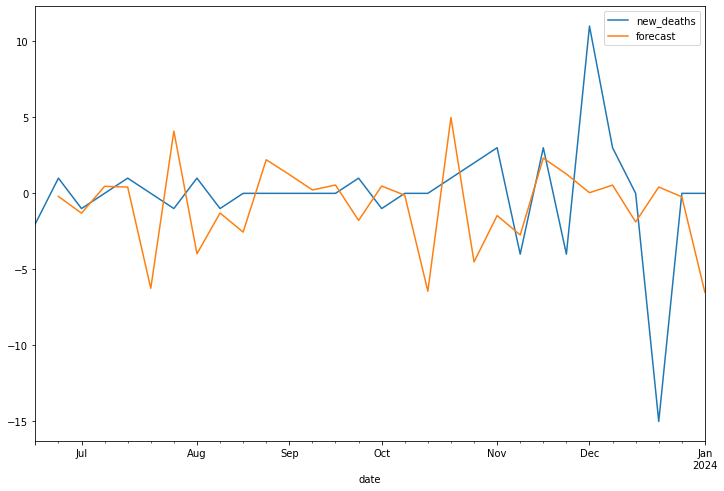

In [11]:
model=sm.tsa.statespace.SARIMAX(estonia_train['new_deaths'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
estonia_test['forecast']=results.predict(start=173,end=202,dynamic=True)
estonia_test[['new_deaths','forecast']].plot(figsize=(12,8))

## autoARIMA

In [23]:
# need un-differenced data

# France

## train/test split

In [12]:
france = pd.read_csv('france_diff.csv')
france = france.set_index('date')
france.index = pd.to_datetime(france.index)
france = france.drop('Unnamed: 0', axis=1)
france.sort_index()
train_size = int(len(france) * 0.8)
france_train, france_test = france[0:train_size], france[train_size:]
france_train=france.iloc[:-30 ]
france_test=france.iloc[-30: ]
print(france_train.shape, france_test.shape)

(172, 1) (30, 1)


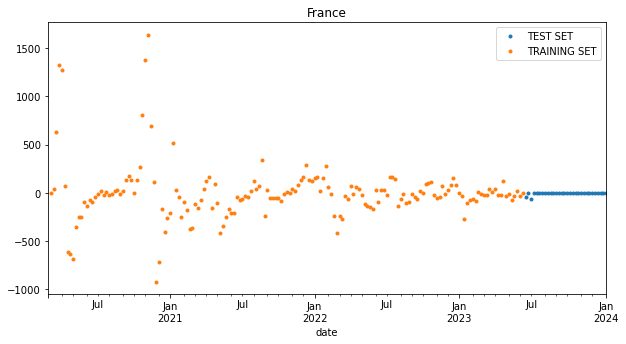

In [13]:
_ = france_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(france_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='France', style='.')

## basic ARIMA (1,1,1)

In [14]:
model=ARIMA(france_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1171.531
Date:                Sat, 17 Feb 2024   AIC                           2349.062
Time:                        16:29:04   BIC                           2358.487
Sample:                    03-01-2020   HQIC                          2352.886
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0326      0.205      0.159      0.874      -0.369       0.434
ma.L1          0.1533      0.213      0.721      0.471      -0.263       0.570
sigma2       5.16e+04   2613.789     19.740      0.000    4.65e+04    5.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               507.01
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                            -1.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

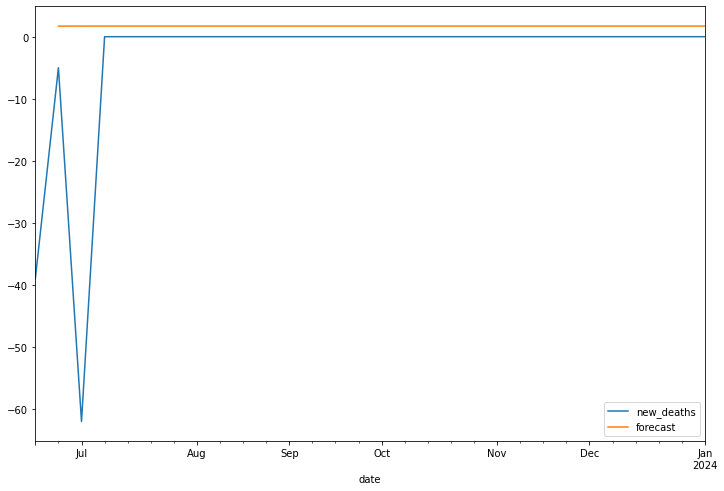

In [15]:
france_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
france_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search ARIMA

In [16]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(france_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
8,3,1,2305.048224
14,4,3,2306.115941
5,2,2,2306.164960
9,3,2,2306.405511
12,4,1,2306.523912
15,4,4,2306.545460
2,1,3,2306.910933
6,2,3,2306.954795
3,1,4,2307.450559
7,2,4,2307.720495


In [17]:
model=ARIMA(france_train['new_deaths'],order=(3,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1147.524
Date:                Sat, 17 Feb 2024   AIC                           2305.048
Time:                        16:29:47   BIC                           2320.757
Sample:                    03-01-2020   HQIC                          2311.422
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9052      0.046     19.493      0.000       0.814       0.996
ar.L2         -0.1986      0.069     -2.866      0.004      -0.334      -0.063
ar.L3         -0.1755      0.046     -3.776      0.000      -0.267      -0.084
ma.L1         -1.0000      0.061    -16.282      0.000      -1.120      -0.880
sigma2      3.787e+04   1.62e-06   2.33e+10      0.000    3.79e+04    3.79e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               188.97
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.63e+26. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

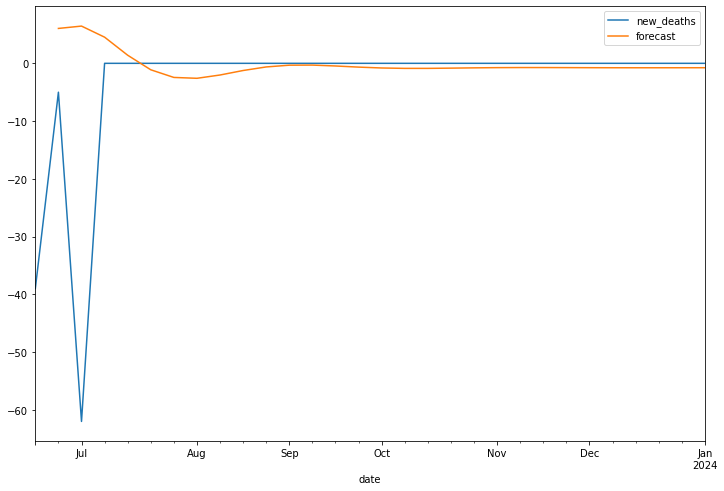

In [18]:
france_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
france_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search SARIMA

In [19]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(france_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47913D+00    |proj g|=  6.31259D-02


 This problem is unconstrained.



At iterate    5    f=  6.45435D+00    |proj g|=  1.16079D-02

At iterate   10    f=  6.45091D+00    |proj g|=  2.43736D-03

At iterate   15    f=  6.44968D+00    |proj g|=  1.14556D-02

At iterate   20    f=  6.41096D+00    |proj g|=  4.54098D-02

At iterate   25    f=  6.37275D+00    |proj g|=  1.77376D-02

At iterate   30    f=  6.36345D+00    |proj g|=  7.35367D-04

At iterate   35    f=  6.36286D+00    |proj g|=  7.14458D-04

At iterate   40    f=  6.36281D+00    |proj g|=  3.35977D-04

At iterate   45    f=  6.36281D+00    |proj g|=  4.62138D-05

At iterate   50    f=  6.36280D+00    |proj g|=  1.18863D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.45280D+00    |proj g|=  2.30227D-02

At iterate   10    f=  6.45118D+00    |proj g|=  1.18913D-03

At iterate   15    f=  6.44998D+00    |proj g|=  1.42182D-02

At iterate   20    f=  6.43806D+00    |proj g|=  1.05332D-02

At iterate   25    f=  6.39670D+00    |proj g|=  1.32529D-03

At iterate   30    f=  6.39667D+00    |proj g|=  1.96695D-04

At iterate   35    f=  6.39664D+00    |proj g|=  1.24436D-03

At iterate   40    f=  6.39657D+00    |proj g|=  1.06304D-03

At iterate   45    f=  6.39652D+00    |proj g|=  5.45250D-03

At iterate   50    f=  6.39648D+00    |proj g|=  9.06972D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.46787D+00    |proj g|=  6.82716D-02

At iterate   10    f=  6.45143D+00    |proj g|=  4.22241D-03

At iterate   15    f=  6.45084D+00    |proj g|=  1.19183D-03

At iterate   20    f=  6.44883D+00    |proj g|=  1.77836D-02

At iterate   25    f=  6.40168D+00    |proj g|=  8.27008D-02

At iterate   30    f=  6.39512D+00    |proj g|=  9.21442D-03

At iterate   35    f=  6.39455D+00    |proj g|=  1.63844D-03

At iterate   40    f=  6.39450D+00    |proj g|=  6.25981D-04

At iterate   45    f=  6.39449D+00    |proj g|=  2.25604D-04

At iterate   50    f=  6.39448D+00    |proj g|=  1.47271D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.45512D+00    |proj g|=  1.63460D-02

At iterate   10    f=  6.45095D+00    |proj g|=  2.04970D-03

At iterate   15    f=  6.45048D+00    |proj g|=  9.59182D-03

At iterate   20    f=  6.43091D+00    |proj g|=  9.08841D-02

At iterate   25    f=  6.39787D+00    |proj g|=  1.12550D-02

At iterate   30    f=  6.39489D+00    |proj g|=  3.30342D-03

At iterate   35    f=  6.39455D+00    |proj g|=  3.48682D-03

At iterate   40    f=  6.39453D+00    |proj g|=  1.18115D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     51      1     0     0   9.258D-06   6.395D+00
  F =   6.39452605285

 This problem is unconstrained.



At iterate    5    f=  6.39172D+00    |proj g|=  2.57128D-02

At iterate   10    f=  6.38291D+00    |proj g|=  2.02628D-02

At iterate   15    f=  6.38073D+00    |proj g|=  4.23942D-03

At iterate   20    f=  6.32854D+00    |proj g|=  5.02030D-02

At iterate   25    f=  6.32327D+00    |proj g|=  2.14252D-03

At iterate   30    f=  6.32273D+00    |proj g|=  1.41462D-03

At iterate   35    f=  6.32265D+00    |proj g|=  1.01414D-03

At iterate   40    f=  6.32264D+00    |proj g|=  1.90852D-04

At iterate   45    f=  6.32264D+00    |proj g|=  7.64375D-05

At iterate   50    f=  6.32264D+00    |proj g|=  1.36142D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46208D+00    |proj g|=  2.48343D-01

At iterate    5    f=  6.39369D+00    |proj g|=  2.19465D-02

At iterate   10    f=  6.38172D+00    |proj g|=  4.62004D-03

At iterate   15    f=  6.38107D+00    |proj g|=  2.66784D-03

At iterate   20    f=  6.34171D+00    |proj g|=  3.46509D-02

At iterate   25    f=  6.32411D+00    |proj g|=  1.07027D-02

At iterate   30    f=  6.32328D+00    |proj g|=  6.95141D-04

At iterate   35    f=  6.32270D+00    |proj g|=  7.52470D-03

At iterate   40    f=  6.32242D+00    |proj g|=  1.95334D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.39471D+00    |proj g|=  8.43315D-02

At iterate   10    f=  6.38375D+00    |proj g|=  6.20530D-03

At iterate   15    f=  6.38122D+00    |proj g|=  1.10130D-02

At iterate   20    f=  6.38074D+00    |proj g|=  2.07738D-03

At iterate   25    f=  6.32818D+00    |proj g|=  5.13563D-02

At iterate   30    f=  6.32335D+00    |proj g|=  2.64093D-03

At iterate   35    f=  6.32258D+00    |proj g|=  3.03393D-03

At iterate   40    f=  6.32246D+00    |proj g|=  2.72993D-04

At iterate   45    f=  6.32244D+00    |proj g|=  4.20560D-04

At iterate   50    f=  6.32243D+00    |proj g|=  1.34992D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47961D+00    |proj g|=  2.67929D-01

At iterate    5    f=  6.39652D+00    |proj g|=  2.09812D-02

At iterate   10    f=  6.38242D+00    |proj g|=  8.25746D-03

At iterate   15    f=  6.38100D+00    |proj g|=  1.61286D-03

At iterate   20    f=  6.37523D+00    |proj g|=  6.34015D-02

At iterate   25    f=  6.32287D+00    |proj g|=  8.73241D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     36      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.42796D+00    |proj g|=  1.07793D-02

At iterate   10    f=  6.41823D+00    |proj g|=  7.72009D-02

At iterate   15    f=  6.38204D+00    |proj g|=  7.26866D-03

At iterate   20    f=  6.37108D+00    |proj g|=  3.41918D-03

At iterate   25    f=  6.33775D+00    |proj g|=  8.10746D-02

At iterate   30    f=  6.29386D+00    |proj g|=  1.15188D-02

At iterate   35    f=  6.29288D+00    |proj g|=  1.37092D-03

At iterate   40    f=  6.29271D+00    |proj g|=  2.74045D-04

At iterate   45    f=  6.29268D+00    |proj g|=  2.89612D-04

At iterate   50    f=  6.29268D+00    |proj g|=  1.52199D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.42768D+00    |proj g|=  3.29932D-03

At iterate   10    f=  6.41512D+00    |proj g|=  5.72143D-02

At iterate   15    f=  6.37425D+00    |proj g|=  1.60571D-02

At iterate   20    f=  6.37211D+00    |proj g|=  4.03708D-03

At iterate   25    f=  6.36800D+00    |proj g|=  6.77751D-03

At iterate   30    f=  6.31628D+00    |proj g|=  7.97318D-02

At iterate   35    f=  6.29611D+00    |proj g|=  1.47867D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     54      1     0     0   1.254D-03   6.296D+00
  F =   6.2961149432732126     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46823D+00    |proj g|=  1.27307D-01

At iterate    5    f=  6.43591D+00    |proj g|=  6.38512D-02

At iterate   10    f=  6.42719D+00    |proj g|=  1.16010D-02

At iterate   15    f=  6.38979D+00    |proj g|=  3.26331D-02

At iterate   20    f=  6.37269D+00    |proj g|=  1.70970D-02

At iterate   25    f=  6.36797D+00    |proj g|=  3.60700D-03

At iterate   30    f=  6.29731D+00    |proj g|=  2.28040D-02

At iterate   35    f=  6.29256D+00    |proj g|=  4.43969D-03

At iterate   40    f=  6.29224D+00    |proj g|=  6.18746D-04

At iterate   45    f=  6.29220D+00    |proj g|=  4.01309D-04

At iterate   50    f=  6.29219D+00    |proj g|=  1.48980D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.42756D+00    |proj g|=  4.18469D-03

At iterate   10    f=  6.41675D+00    |proj g|=  5.99622D-02

At iterate   15    f=  6.37714D+00    |proj g|=  2.61048D-02

At iterate   20    f=  6.37098D+00    |proj g|=  1.10444D-02

At iterate   25    f=  6.31313D+00    |proj g|=  6.74003D-02

At iterate   30    f=  6.29341D+00    |proj g|=  5.97911D-03

At iterate   35    f=  6.29281D+00    |proj g|=  1.16259D-02

At iterate   40    f=  6.29235D+00    |proj g|=  1.58251D-03

At iterate   45    f=  6.29233D+00    |proj g|=  8.79552D-05

At iterate   50    f=  6.29233D+00    |proj g|=  3.93029D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.38596D+00    |proj g|=  3.09877D-02

At iterate   10    f=  6.36762D+00    |proj g|=  7.22710D-03

At iterate   15    f=  6.35833D+00    |proj g|=  1.21620D-02

At iterate   20    f=  6.35653D+00    |proj g|=  5.18182D-03

At iterate   25    f=  6.35253D+00    |proj g|=  8.61607D-03

At iterate   30    f=  6.33021D+00    |proj g|=  2.09064D-02

At iterate   35    f=  6.31075D+00    |proj g|=  5.04030D-02

At iterate   40    f=  6.27643D+00    |proj g|=  3.12718D-03

At iterate   45    f=  6.27639D+00    |proj g|=  3.30384D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     58   

 This problem is unconstrained.



At iterate    5    f=  6.38924D+00    |proj g|=  2.50356D-02

At iterate   10    f=  6.36133D+00    |proj g|=  1.80469D-02

At iterate   15    f=  6.35801D+00    |proj g|=  7.01795D-03

At iterate   20    f=  6.35231D+00    |proj g|=  5.47940D-03

At iterate   25    f=  6.35072D+00    |proj g|=  6.73896D-03

At iterate   30    f=  6.29088D+00    |proj g|=  4.42182D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     50      1     0     0   4.452D-02   6.291D+00
  F =   6.2908787205329295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47395D+00    |proj g|=  2.57631D-01

At iterate    5    f=  6.39460D+00    |proj g|=  1.59217D-01

At iterate   10    f=  6.36660D+00    |proj g|=  2.50645D-02

At iterate   15    f=  6.35668D+00    |proj g|=  6.56937D-03

At iterate   20    f=  6.35411D+00    |proj g|=  8.94775D-03

At iterate   25    f=  6.35219D+00    |proj g|=  6.23214D-03

At iterate   30    f=  6.29567D+00    |proj g|=  5.35419D-02

At iterate   35    f=  6.27477D+00    |proj g|=  5.50564D-04

At iterate   40    f=  6.27475D+00    |proj g|=  1.47263D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.39143D+00    |proj g|=  1.89090D-02

At iterate   10    f=  6.36625D+00    |proj g|=  5.32797D-02

At iterate   15    f=  6.35508D+00    |proj g|=  3.09381D-03

At iterate   20    f=  6.35297D+00    |proj g|=  1.59332D-02

At iterate   25    f=  6.34867D+00    |proj g|=  4.49612D-02

At iterate   30    f=  6.27948D+00    |proj g|=  1.98624D-02

At iterate   35    f=  6.27631D+00    |proj g|=  6.77633D-03

At iterate   40    f=  6.27621D+00    |proj g|=  9.38153D-05

At iterate   45    f=  6.27621D+00    |proj g|=  3.42496D-04

At iterate   50    f=  6.27620D+00    |proj g|=  1.47333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [20]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
12,2,2,1,1,2173.077379
14,2,2,2,1,2174.511851
8,2,1,1,1,2176.680724
15,2,2,2,2,2177.012173
10,2,1,2,1,2178.512801
9,2,1,1,2,2179.863540
13,2,2,1,2,2180.062280
11,2,1,2,2,2180.562310
4,1,2,1,1,2186.987842
5,1,2,1,2,2188.910922


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46838D+00    |proj g|=  2.39536D-01

At iterate    5    f=  6.38596D+00    |proj g|=  3.09877D-02

At iterate   10    f=  6.36762D+00    |proj g|=  7.22710D-03

At iterate   15    f=  6.35833D+00    |proj g|=  1.21620D-02

At iterate   20    f=  6.35653D+00    |proj g|=  5.18182D-03

At iterate   25    f=  6.35253D+00    |proj g|=  8.61607D-03

At iterate   30    f=  6.33021D+00    |proj g|=  2.09064D-02

At iterate   35    f=  6.31075D+00    |proj g|=  5.04030D-02

At iterate   40    f=  6.27643D+00    |proj g|=  3.12718D-03

At iterate   45    f=  6.27639D+00    |proj g|=  3.30384D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<AxesSubplot:xlabel='date'>

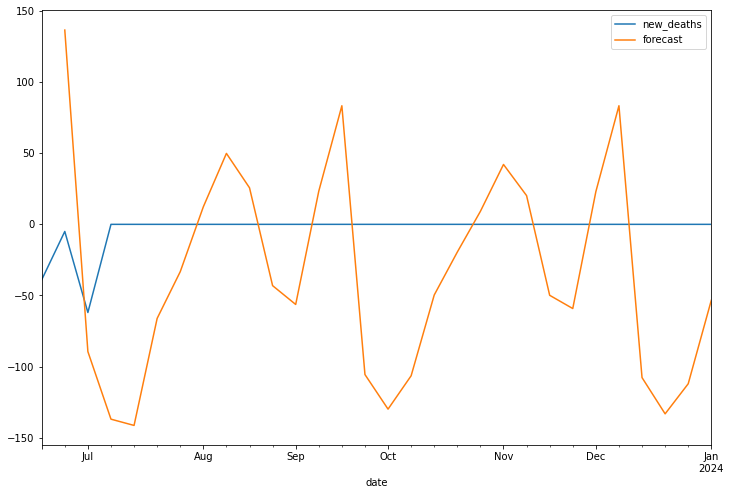

In [21]:
model=sm.tsa.statespace.SARIMAX(france_train['new_deaths'],order=(2, 1, 2),seasonal_order=(1,1,1,12))
results=model.fit()
france_test['forecast']=results.predict(start=173,end=202,dynamic=True)
france_test[['new_deaths','forecast']].plot(figsize=(12,8))

## autoARIMA

In [24]:
# need un-differenced data

# Malaysia

## train/test split

In [22]:
malaysia = pd.read_csv('malaysia_diff.csv')
malaysia = malaysia.set_index('date')
malaysia.index = pd.to_datetime(malaysia.index)
malaysia = malaysia.drop('Unnamed: 0', axis=1)
malaysia.sort_index()
train_size = int(len(malaysia) * 0.8)
malaysia_train, malaysia_test = malaysia[0:train_size], malaysia[train_size:]
malaysia_train=malaysia.iloc[:-30 ]
malaysia_test=malaysia.iloc[-30: ]
print(malaysia_train.shape, malaysia_test.shape)

(172, 1) (30, 1)


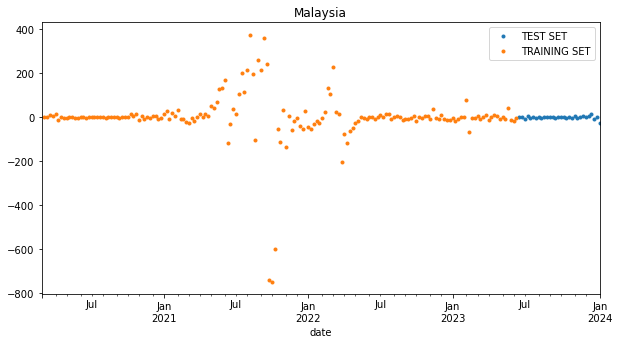

In [23]:
_ = malaysia_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(malaysia_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Malaysia', style='.')

## basic ARIMA (1,1,1)

In [24]:
model=ARIMA(malaysia_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1028.193
Date:                Sat, 17 Feb 2024   AIC                           2062.386
Time:                        16:31:31   BIC                           2071.811
Sample:                    03-01-2020   HQIC                          2066.211
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5812      0.030     19.676      0.000       0.523       0.639
ma.L1         -0.9998      2.014     -0.497      0.620      -4.946       2.947
sigma2      9358.2304    1.9e+04      0.492      0.623   -2.79e+04    4.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.73   Jarque-Bera (JB):             12957.96
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               4.52   Skew:                            -4.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

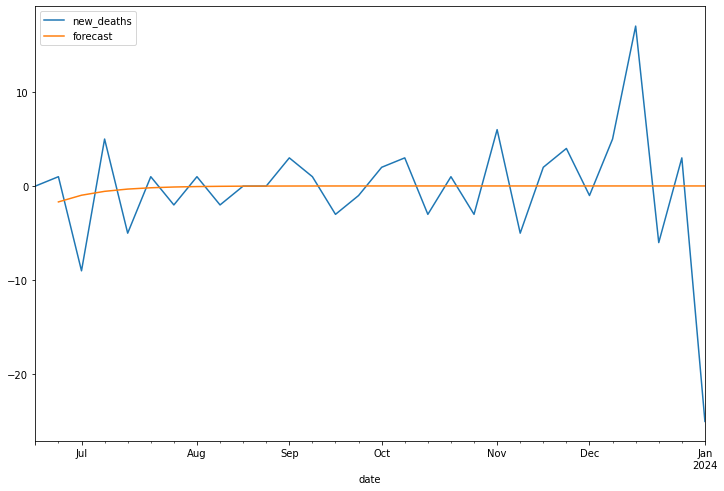

In [25]:
malaysia_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
malaysia_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search ARIMA

In [26]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(malaysia_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
10,3,3,2046.407557
7,2,4,2046.872979
6,2,3,2048.276076
14,4,3,2048.349072
11,3,4,2048.353857
15,4,4,2050.470358
12,4,1,2054.335701
2,1,3,2055.236250
8,3,1,2055.565252
3,1,4,2055.729133


In [27]:
model=ARIMA(malaysia_train['new_deaths'],order=(3,1,3))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  172
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1016.204
Date:                Sat, 17 Feb 2024   AIC                           2046.408
Time:                        16:32:12   BIC                           2068.399
Sample:                    03-01-2020   HQIC                          2055.331
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7055      0.118      5.999      0.000       0.475       0.936
ar.L2         -0.7608      0.135     -5.647      0.000      -1.025      -0.497
ar.L3          0.2158      0.084      2.565      0.010       0.051       0.381
ma.L1         -1.0422     14.079     -0.074      0.941     -28.637      26.552
ma.L2          0.8089      0.659      1.228      0.220      -0.483       2.100
ma.L3         -0.7666     10.820     -0.071      0.944     -21.974      20.440
sigma2      8079.2026   1.14e+05      0.071      0.943   -2.15e+05    2.31e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9181.47
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               5.57   Skew:                            -3.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

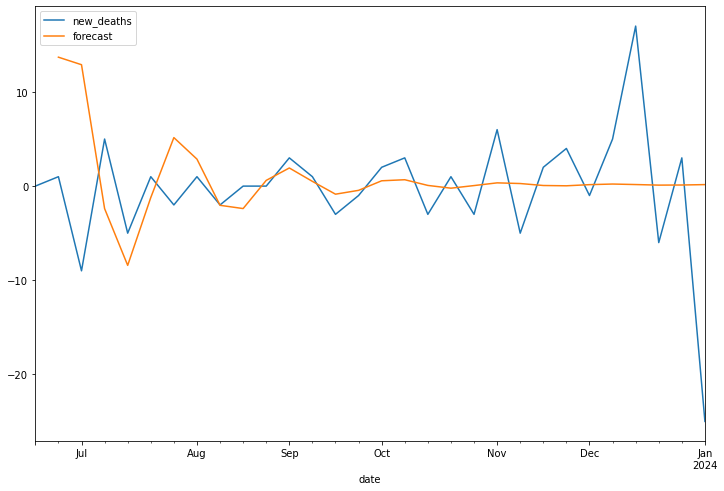

In [28]:
malaysia_test['forecast']=model_fit.predict(start=173,end=202,dynamic=True)
malaysia_test[['new_deaths','forecast']].plot(figsize=(12,8))

## grid search SARIMA

In [29]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(malaysia_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.82584D+00    |proj g|=  5.24380D-02

At iterate    5    f=  5.78435D+00    |proj g|=  1.24173D-02


 This problem is unconstrained.



At iterate   10    f=  5.76445D+00    |proj g|=  2.34762D-02

At iterate   15    f=  5.73186D+00    |proj g|=  1.95987D-02

At iterate   20    f=  5.71644D+00    |proj g|=  3.56582D-02

At iterate   25    f=  5.64806D+00    |proj g|=  3.56794D-02

At iterate   30    f=  5.64626D+00    |proj g|=  5.50809D-03

At iterate   35    f=  5.64581D+00    |proj g|=  2.05289D-03

At iterate   40    f=  5.64577D+00    |proj g|=  4.05646D-04

At iterate   45    f=  5.64577D+00    |proj g|=  8.88004D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     61      1     0     0   8.382D-05   5.646D+00
  F =   5.64576729610

 This problem is unconstrained.



At iterate    5    f=  5.78263D+00    |proj g|=  5.54251D-03

At iterate   10    f=  5.75831D+00    |proj g|=  1.48991D-02

At iterate   15    f=  5.72544D+00    |proj g|=  5.80209D-03

At iterate   20    f=  5.64714D+00    |proj g|=  8.54656D-03

At iterate   25    f=  5.64704D+00    |proj g|=  6.87347D-04

At iterate   30    f=  5.64697D+00    |proj g|=  2.90372D-03

At iterate   35    f=  5.64645D+00    |proj g|=  7.64596D-03

At iterate   40    f=  5.64503D+00    |proj g|=  7.38718D-03

At iterate   45    f=  5.64404D+00    |proj g|=  1.00505D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     85   

 This problem is unconstrained.



At iterate    5    f=  5.80185D+00    |proj g|=  1.10989D-01

At iterate   10    f=  5.76526D+00    |proj g|=  3.85669D-02

At iterate   15    f=  5.74919D+00    |proj g|=  1.90357D-02

At iterate   20    f=  5.68376D+00    |proj g|=  1.61526D-01

At iterate   25    f=  5.64332D+00    |proj g|=  1.46863D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     34      1     0     0   1.367D-05   5.643D+00
  F =   5.6433242638988768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  5.78217D+00    |proj g|=  8.68483D-03

At iterate   10    f=  5.77882D+00    |proj g|=  5.98237D-02

At iterate   15    f=  5.74937D+00    |proj g|=  5.01310D-02

At iterate   20    f=  5.72911D+00    |proj g|=  6.63797D-03

At iterate   25    f=  5.64853D+00    |proj g|=  1.21448D-02

At iterate   30    f=  5.64688D+00    |proj g|=  1.55114D-02

At iterate   35    f=  5.64246D+00    |proj g|=  2.14190D-02

At iterate   40    f=  5.64003D+00    |proj g|=  6.37455D-04

At iterate   45    f=  5.63969D+00    |proj g|=  2.71645D-03

At iterate   50    f=  5.63950D+00    |proj g|=  2.31489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.82939D+00    |proj g|=  5.42660D-02

At iterate    5    f=  5.78753D+00    |proj g|=  1.76218D-02

At iterate   10    f=  5.77973D+00    |proj g|=  4.15015D-03

At iterate   15    f=  5.72265D+00    |proj g|=  7.20740D-02

At iterate   20    f=  5.64489D+00    |proj g|=  1.42200D-02

At iterate   25    f=  5.63707D+00    |proj g|=  4.10665D-03

At iterate   30    f=  5.63635D+00    |proj g|=  7.03165D-04

At iterate   35    f=  5.63629D+00    |proj g|=  1.37513D-04

At iterate   40    f=  5.63628D+00    |proj g|=  9.02316D-05

At iterate   45    f=  5.63628D+00    |proj g|=  4.74897D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80430D+00    |proj g|=  3.68439D-02

At iterate    5    f=  5.78356D+00    |proj g|=  2.06925D-02

At iterate   10    f=  5.77928D+00    |proj g|=  6.03606D-03

At iterate   15    f=  5.63844D+00    |proj g|=  2.04760D-02

At iterate   20    f=  5.63751D+00    |proj g|=  3.64619D-04

At iterate   25    f=  5.63716D+00    |proj g|=  1.89189D-04

At iterate   30    f=  5.63701D+00    |proj g|=  4.83176D-04

At iterate   35    f=  5.63699D+00    |proj g|=  2.31029D-04

At iterate   40    f=  5.63698D+00    |proj g|=  5.69625D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  5.79383D+00    |proj g|=  4.32066D-02

At iterate   10    f=  5.77997D+00    |proj g|=  3.36879D-03

At iterate   15    f=  5.77627D+00    |proj g|=  9.81482D-03

At iterate   20    f=  5.63683D+00    |proj g|=  4.32475D-02

At iterate   25    f=  5.63335D+00    |proj g|=  5.32398D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     32      1     0     0   7.686D-06   5.633D+00
  F =   5.6333532867957219     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  5.78588D+00    |proj g|=  1.33941D-02

At iterate   10    f=  5.77984D+00    |proj g|=  7.10630D-03

At iterate   15    f=  5.76750D+00    |proj g|=  4.34607D-02

At iterate   20    f=  5.64645D+00    |proj g|=  1.53533D-02

At iterate   25    f=  5.64035D+00    |proj g|=  2.97759D-02

At iterate   30    f=  5.63152D+00    |proj g|=  1.20080D-02

At iterate   35    f=  5.63088D+00    |proj g|=  7.54563D-04

At iterate   40    f=  5.63052D+00    |proj g|=  1.60484D-03

At iterate   45    f=  5.63036D+00    |proj g|=  8.03349D-04

At iterate   50    f=  5.63008D+00    |proj g|=  9.19836D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.75497D+00    |proj g|=  3.92716D-02

At iterate   10    f=  5.73292D+00    |proj g|=  8.64492D-03

At iterate   15    f=  5.72498D+00    |proj g|=  6.08265D-03

At iterate   20    f=  5.64374D+00    |proj g|=  3.18285D-02

At iterate   25    f=  5.63147D+00    |proj g|=  8.86076D-03

At iterate   30    f=  5.62983D+00    |proj g|=  1.15906D-03

At iterate   35    f=  5.62970D+00    |proj g|=  4.54688D-04

At iterate   40    f=  5.62969D+00    |proj g|=  1.77755D-04

At iterate   45    f=  5.62968D+00    |proj g|=  4.57509D-04

At iterate   50    f=  5.62968D+00    |proj g|=  6.93649D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78345D+00    |proj g|=  6.17416D-02

At iterate    5    f=  5.76601D+00    |proj g|=  6.43861D-02

At iterate   10    f=  5.74531D+00    |proj g|=  1.53233D-02

At iterate   15    f=  5.72357D+00    |proj g|=  8.79758D-03

At iterate   20    f=  5.66679D+00    |proj g|=  1.47496D-01

At iterate   25    f=  5.63125D+00    |proj g|=  3.87088D-03

At iterate   30    f=  5.63095D+00    |proj g|=  8.96520D-03

At iterate   35    f=  5.63023D+00    |proj g|=  4.16024D-03

At iterate   40    f=  5.63021D+00    |proj g|=  1.50647D-04

At iterate   45    f=  5.63021D+00    |proj g|=  1.32556D-03

At iterate   50    f=  5.63017D+00    |proj g|=  1.43344D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.82482D+00    |proj g|=  8.21930D-02

At iterate    5    f=  5.78749D+00    |proj g|=  1.10659D-01

At iterate   10    f=  5.73640D+00    |proj g|=  1.09848D-02

At iterate   15    f=  5.72492D+00    |proj g|=  1.59765D-02

At iterate   20    f=  5.71680D+00    |proj g|=  4.04150D-03

At iterate   25    f=  5.62966D+00    |proj g|=  2.76282D-02

At iterate   30    f=  5.62722D+00    |proj g|=  8.67130D-03

At iterate   35    f=  5.62670D+00    |proj g|=  2.97330D-03

At iterate   40    f=  5.62665D+00    |proj g|=  4.47759D-04

At iterate   45    f=  5.62664D+00    |proj g|=  5.54807D-04

At iterate   50    f=  5.62664D+00    |proj g|=  8.68778D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79035D+00    |proj g|=  6.17281D-02

At iterate    5    f=  5.76247D+00    |proj g|=  6.32774D-02

At iterate   10    f=  5.74279D+00    |proj g|=  3.08351D-02

At iterate   15    f=  5.72366D+00    |proj g|=  1.96260D-02

At iterate   20    f=  5.71968D+00    |proj g|=  4.49303D-02

At iterate   25    f=  5.63249D+00    |proj g|=  4.87458D-03

At iterate   30    f=  5.63203D+00    |proj g|=  1.26534D-02

At iterate   35    f=  5.62908D+00    |proj g|=  2.12524D-03

At iterate   40    f=  5.62597D+00    |proj g|=  2.83730D-02

At iterate   45    f=  5.62454D+00    |proj g|=  4.09285D-03

At iterate   50    f=  5.62450D+00    |proj g|=  3.17152D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.78642D+00    |proj g|=  2.47301D-02

At iterate   10    f=  5.78090D+00    |proj g|=  1.58034D-02

At iterate   15    f=  5.77432D+00    |proj g|=  8.39596D-03

At iterate   20    f=  5.75299D+00    |proj g|=  5.41281D-02

At iterate   25    f=  5.64482D+00    |proj g|=  4.22898D-03

At iterate   30    f=  5.64472D+00    |proj g|=  3.47639D-03

At iterate   35    f=  5.64428D+00    |proj g|=  1.02625D-02

At iterate   40    f=  5.63530D+00    |proj g|=  7.02194D-04

At iterate   45    f=  5.63518D+00    |proj g|=  4.33294D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     93      1     0     0   4.354D-05   5.635D+00
  F =   5.6351755373434056     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80524D+00    |proj g|=  5.03422D-02

At iterate    5    f=  5.78633D+00    |proj g|=  2.86733D-02

At iterate   10    f=  5.77978D+00    |proj g|=  1.49339D-02

At iterate   15    f=  5.77104D+00    |proj g|=  3.39452D-03


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83185D+00    |proj g|=  6.67135D-02

At iterate    5    f=  5.80214D+00    |proj g|=  8.23265D-02

At iterate   10    f=  5.77869D+00    |proj g|=  1.29166D-02

At iterate   15    f=  5.77419D+00    |proj g|=  5.29095D-03

At iterate   20    f=  5.76800D+00    |proj g|=  2.16060D-02

At iterate   25    f=  5.65601D+00    |proj g|=  1.19615D-01

At iterate   30    f=  5.63367D+00    |proj g|=  3.19590D-02

At iterate   35    f=  5.63223D+00    |proj g|=  2.17844D-03

At iterate   40    f=  5.62990D+00    |proj g|=  3.70443D-02

At iterate   45    f=  5.62304D+00    |proj g|=  1.51654D-02

At iterate   50    f=  5.62265D+00    |proj g|=  7.68340D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.78409D+00    |proj g|=  1.74170D-02

At iterate   10    f=  5.77379D+00    |proj g|=  1.15011D-02

At iterate   15    f=  5.77069D+00    |proj g|=  4.10575D-03

At iterate   20    f=  5.67704D+00    |proj g|=  1.58578D+00
  ys=-1.706E+02  -gs= 1.224E-01 BFGS update SKIPPED
  ys=-1.222E+09  -gs= 4.310E+03 BFGS update SKIPPED


LinAlgError: LU decomposition error.

In [30]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
8,2,1,1,1,1948.611017
10,2,1,2,1,1949.564847
14,2,2,2,1,1950.191704
9,2,1,1,2,1950.776995
11,2,1,2,2,1950.828369
4,1,2,1,1,1950.880864
6,1,2,2,1,1951.873531
0,1,1,1,1,1952.143950
12,2,2,1,1,1952.500385
7,1,2,2,2,1952.746579


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.82436D+00    |proj g|=  8.91051D-02

At iterate    5    f=  5.75497D+00    |proj g|=  3.92716D-02


 This problem is unconstrained.



At iterate   10    f=  5.73292D+00    |proj g|=  8.64492D-03

At iterate   15    f=  5.72498D+00    |proj g|=  6.08265D-03

At iterate   20    f=  5.64374D+00    |proj g|=  3.18285D-02

At iterate   25    f=  5.63147D+00    |proj g|=  8.86076D-03

At iterate   30    f=  5.62983D+00    |proj g|=  1.15906D-03

At iterate   35    f=  5.62970D+00    |proj g|=  4.54688D-04

At iterate   40    f=  5.62969D+00    |proj g|=  1.77755D-04

At iterate   45    f=  5.62968D+00    |proj g|=  4.57509D-04

At iterate   50    f=  5.62968D+00    |proj g|=  6.93649D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61   

<AxesSubplot:xlabel='date'>

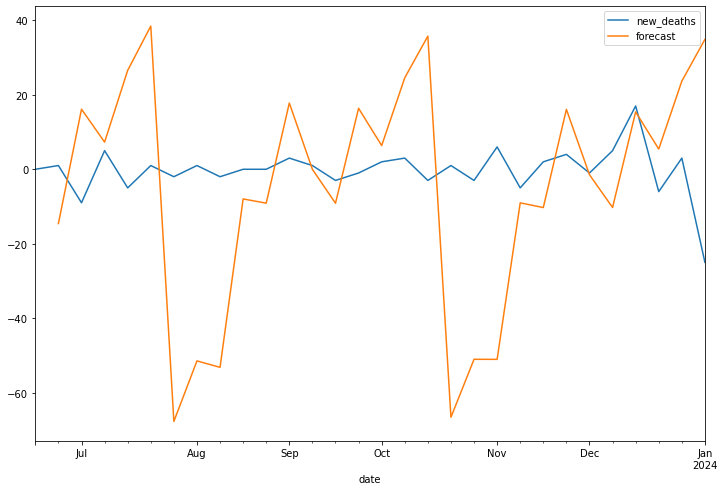

In [31]:
model=sm.tsa.statespace.SARIMAX(malaysia_train['new_deaths'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
malaysia_test['forecast']=results.predict(start=173,end=202,dynamic=True)
malaysia_test[['new_deaths','forecast']].plot(figsize=(12,8))

## autoARIMA

In [25]:
# need un-differenced data